# Bank Marketing Project 

### Joel Mott, January 2024

## Introduction

This project optimizes three different kinds of classification models to find the best one for predicting which customers to target in a bank's marketing campaign. For each model, I establish a baseline instance, then experiment with over & under-sampling techniques as well as hyperparamater tuning. 

Keeping the stakeholder's specific interests in focus while also understanding the nature and distribution of the data, I find that a decision tree model with a specific undersampling strategy and max_depth parameter mode make for the best predictions.

The data is from a bank marketing campaign where existing customers were contacted by phone in an attempt to have them open a term deposit. Unlike a checking account, term deposit funds cannot be withdrawn without penalties for a predetermined amount of time. In return, the customer is offered higher interest rates. 

Only 11.7% of customers wound up opening a term deposit; my goal is to help increase that percentage for their next marketing campaign. Subsequently, each modeling process will also deal with class-imbalance issues.

### Dataset

This project makes use of a [Kaggle dataset from a bank's term deposit marketing campaign](https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets/data) that originally comes in two files: one is the training set and the other is the test set. Altogether, they contain just under 50,000 records, each representing an existing customer who was contacted as a part of this marketing effort. 

It also contains fifteen attributes and one target column, which indicates whether the customer opened a term account. The attributes include age, education level, current checking account balance, whether they've opened such an account before or have another loan with the bank, whether they've defaulted on a loan before, and data on how previous marketing efforts went for the client. I cover these features in-depth below. 

This data is pretty clean and comprehensive (no NaN's, although there are some features with "unknown" categories). 

### Goals

The problem is narrowing down which existing clients to pay a call center to contact over the phone; we want to minimize the amount of calls made to clients without missing out on too many new term deposits. Ideally, we would know how much the bank usually profits from term deposits as well as approximately how much each call costs them. 

Since we don't have those details, I evaluate the data with a substantial (but not absolute) bias toward reducing false negatives (predicting someone won't make a term deposit when they actually would) as opposed to false positives (a *few* wasted calls is probably not as big a deal as a missed deposit). 

### Overview

After some exploratory data anaylsis where I get to know the dataset's features, target, and their distributions, I build a baseline Scikit-Learn decision tree model and refine it with over & undersampling techniques as well as hyperparameter-tuning. Next, I go through a similar process for a StatsModel's Logistic Regression (Logit) model and a Scikit-Learn Logit model. 

I evaluate each of these three types of models' baselines and then refine them by measuring recall, area-under-the-curve (AUC), and confusion matrices. 

The decision tree results in the best prediction results for balancing new term deposits with call center costs, but both the StatsModels and Scikit-Learn models offer valuable insights that inform future marketing campaigns.

## Exploratoy Data Analysis (EDA)

Below, we get started by importing the tools for reading-in and getting to know this dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#This dataset came in two files: a training set and a test set
train_df = pd.read_csv('dataset_files/bank_marketing_train.csv', sep=';')
test_df = pd.read_csv('dataset_files/bank_marketing_test.csv', sep=';')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Its' great to see that there aren't any nulls in our summary, but we'll also investigate each column to see whether they've been categorized (as "unknown" or something). Let's also take a glance of the training data and then check out the test file:

In [4]:
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [6]:
test_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


It looks like there are some "unknowns" here that we'll have to contend with. 

Also, we can see that the train file holds 90% of the data and the test file holds the other 10% (they both include the target column, "y"). I think that ratio is a little too high and an 80/20 split would allow for a more thorough test set. 

Subsequently, I'm going to concatenate these two files and *then* perform a new train-test split:

In [7]:
rejoined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
rejoined_df.head() 

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Tidying up the datetime columns and performing the train-test-split

Before doing a train-test-split, it turns out that the month & day columns don't offer much in the way of useful information. We don't know whether this campaign took place over the course of one or multiple years and it appears that the calls were mostly made in May through August with a couple spikes in February and November. 

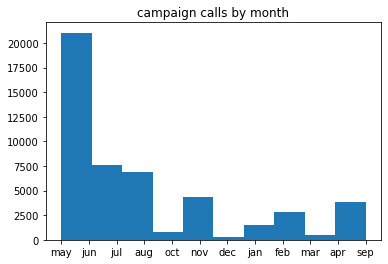

In [8]:
fig, ax = plt.subplots()
ax.hist(rejoined_df['month'])
ax.set_title("campaign calls by month");

Part of making the most of this data means only using meaningful features and this date data doesn't make the cut. If we drop it, we won't lose anything important and our models will be able to work with more concise data with less noise, so let's omit the 'month' and 'day' columns from consideration.

In [9]:
rejoined_df.drop(['month', 'day'], axis=1, inplace=True)

One change I can make without data leakage would be to turn the target column ("y") values into 0's and 1's (for "no" and "yes", respectively). 

In [10]:
rejoined_df.replace({'no': 0, 'yes': 1}, inplace=True)
rejoined_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,198,1,-1,0,unknown,0


Let's try to keep the categorical column one-hot encoding minimal and transform the education column to numbers since it lends itself well to numerical categories anyway:

In [11]:
education_dict = {'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3}
rejoined_df['education'] = rejoined_df['education'].map(education_dict)
rejoined_df['education'].value_counts()

2    25508
3    14651
1     7529
0     2044
Name: education, dtype: int64

With these changes in place, we can go ahead and perform the train-test split with a more robust test set at an 80-20 ratio:

In [12]:
X = rejoined_df.drop('y', axis=1)
y = rejoined_df['y']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=713)

In [13]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
22065,51,housemaid,married,1,0,3486,0,0,cellular,135,11,-1,0,unknown
23946,54,blue-collar,married,2,0,466,0,0,cellular,436,4,-1,0,unknown
14232,35,blue-collar,married,2,0,1287,1,0,cellular,330,2,-1,0,unknown
15211,50,blue-collar,married,2,0,19,0,0,cellular,209,4,-1,0,unknown
24198,34,technician,single,2,0,105,1,0,cellular,303,1,196,2,failure


## Understanding each feature more carefully

Some columns are self-explanatory, such as 'age', 'job', 'marital' status, 'education' level, best way to 'contact', and the target ('y'). Others are not as straightforward, so let's consult [the data dictionary found with the dataset here](https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets/data):

**basic client information:**
- 'default' shows whether they've defaulted on credit before
- 'balance' refers to the average yearly account balance
- 'housing' (yes/no) shows whether they have a housing loan
- 'loan' (yes/no) shows whether they have a personal loan

**current marketing campaign data:**
- 'campaign' refers to the 'number of contacts performed during this campaign and for this client' and this also 'includes the last contact'

**previous campaign data:**
- 'pdays' refers to the 'number of days that passed by after the client was last contacted from a previous campaign' and '-1 means client was not previously contacted'
- 'previous' refers to the 'number of contacts performed before this campaign and for this client'
- 'poutcome' refers to the 'outcome of the previous marketing campaign'

### Let's also examine how these columns' values are distributed. First, the continuous features:

In [14]:
X_train_continuous = X_train[['age', 'balance', 'campaign', 'pdays', 'previous']]

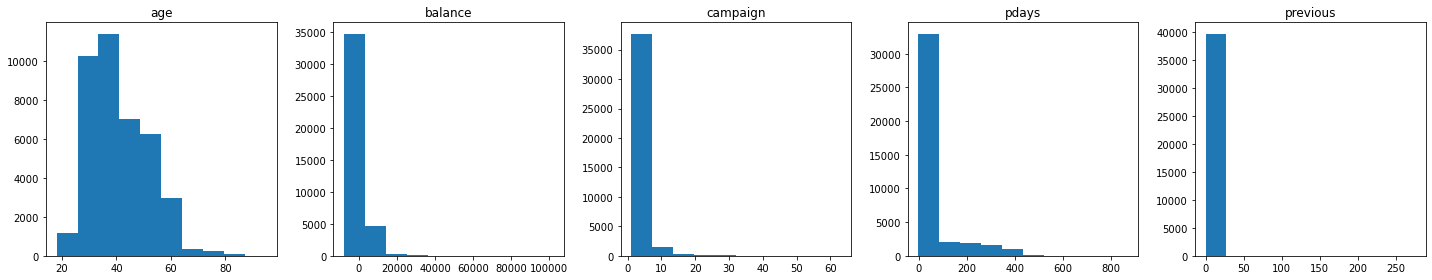

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
for index, col in enumerate(X_train_continuous):
    axes[index].hist(X_train_continuous[col])
    axes[index].set_title(X_train_continuous.columns[index])
plt.tight_layout();

Each of these distributions skew left. It turns out that [continuous features do not need to be normally distributed in a decision tree classification problem](https://www.sciencedirect.com/topics/nursing-and-health-professions/logistic-regression-analysis#:~:text=Logistic%20regression%20does%20not%20assume,equal%20variance%20within%20each%20group), but I should normalize them for the StatsModels and Scikit-Learn Logit models. 

Also, it's worth noting that all these attributes except for 'age' start on zero and all of them contain a few high outliers. 

### Now let's see how the categorical columns look. 

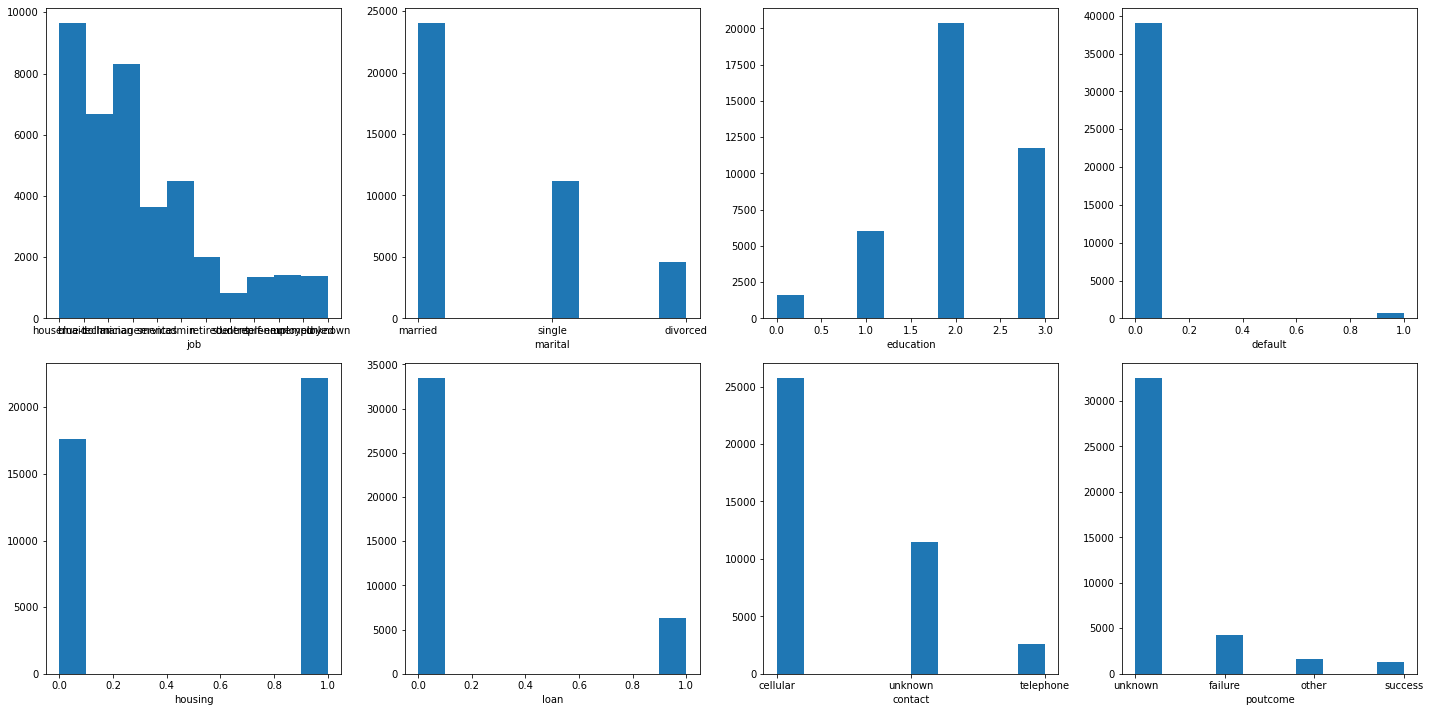

In [16]:
X_train_categorical = X_train[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
for i, column in enumerate(X_train_categorical.columns):
    row = i//4
    col = i%4
    ax = axes[row][col]
#    ax.hist(column, density=True)
#    ax.hist(column, bins='auto')
    ax.hist(X_train[column])
    ax.set_xlabel(column)
plt.tight_layout();

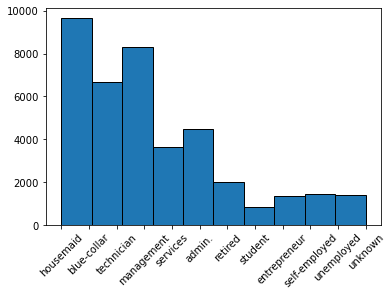

In [17]:
#The first one ('job') is hard to see, here it is on its own.
plt.hist(X_train['job'], edgecolor='black')
plt.xticks(rotation=45);

So, when it comes to issue of entropy, it looks like the 'default' and 'loan' columns would make the best case for earlier splits in a decision tree, with 'poutcome' next, then probably 'marital', 'contact', and 'education' won't be too far behind, then 'job' and 'housing' round out the end of the line. Of course, we won't know for sure until we run a decision tree model. 

## preprocessing training data

Before we start modelling, let's preprocess X_train by one-hot encoding the categorical features:

In [18]:
from sklearn.preprocessing import OneHotEncoder
#one-hot encoding the categorical columns
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
columns_to_ohe = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
encoded = ohe.fit_transform(X_train[columns_to_ohe])
encoded

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [19]:
#turning the array above back into a DataFrame
X_train_categorical_ohe = pd.DataFrame(encoded,
                                      columns=ohe.get_feature_names_out(),
                                      index=X_train.index)
X_train_preprocessed = pd.concat([X_train, X_train_categorical_ohe], axis=1).drop(columns_to_ohe, axis=1)
X_train_preprocessed.info()
X_train_preprocessed.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39785 entries, 22065 to 21197
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                39785 non-null  int64  
 1   balance            39785 non-null  int64  
 2   duration           39785 non-null  int64  
 3   campaign           39785 non-null  int64  
 4   pdays              39785 non-null  int64  
 5   previous           39785 non-null  int64  
 6   job_blue-collar    39785 non-null  float64
 7   job_entrepreneur   39785 non-null  float64
 8   job_housemaid      39785 non-null  float64
 9   job_management     39785 non-null  float64
 10  job_retired        39785 non-null  float64
 11  job_self-employed  39785 non-null  float64
 12  job_services       39785 non-null  float64
 13  job_student        39785 non-null  float64
 14  job_technician     39785 non-null  float64
 15  job_unemployed     39785 non-null  float64
 16  job_unknown       

,age,balance,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,education_2,education_3,default_1,housing_1,loan_1,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
22065,51,3486,135,11,-1,0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23946,54,466,436,4,-1,0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14232,35,1287,330,2,-1,0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
15211,50,19,209,4,-1,0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
24198,34,105,303,1,196,2,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Building a decision tree model

I think a decision tree is the best way to untangle these attributes at first because they're so different. Entropy will be a helpful way to gain first insights into how these features relate to whether or not someone opened a term deposit. Also, it may be helpful later on to normalize the continuous features for the two Logit models and work with them one after the other.  

Decision trees are all about how you set them up, prune them, and tune their hyperparameters. To that end, our "baseline" here is a "vanilla" model where we don't do any of that.

In [20]:
#Importing everything we'll need for our baseline model
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [21]:
#instantiating & fitting the DecisionTreeClassifier model
clf_baseline = DecisionTreeClassifier(criterion='entropy', random_state=713)
clf_baseline.fit(X_train_preprocessed, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=713)

In [22]:
#Checking out the tree plot
fig, ax = plt.subplots(figsize=(20,30))
tree.plot_tree(clf_baseline,
              feature_names = X_train_preprocessed.columns,
              class_names = np.unique(y).astype('str'),
              filled=True)
plt.show();

Wow, what a monstrosity. We'll definitely need to prune this tree. 

### Evaluating the baseline model

Let's get a preliminary sense of how the model is doing with a confusion matrix.

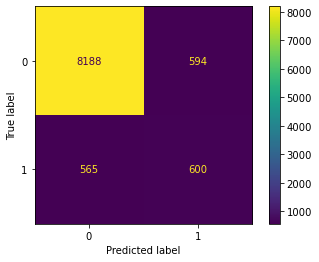

In [25]:
#transforming X_test with OneHotEncoder 
encoded = ohe.transform(X_test[columns_to_ohe])
X_test_categorical_ohe = pd.DataFrame(encoded,
                                      columns=ohe.get_feature_names_out(),
                                      index=X_test.index)
X_test_preprocessed = pd.concat([X_test, X_test_categorical_ohe], axis=1).drop(columns_to_ohe, axis=1)

#making our y_test predictions
y_pred_test_baseline = clf_baseline.predict(X_test_preprocessed)

#confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_baseline); 

In [26]:
y_train.value_counts(normalize=True)

0    0.883247
1    0.116753
Name: y, dtype: float64

Ideally, we'd have no false positives or negatives and 88.3%/11.7% true negatives/positives. With that in mind, let's break down this confusion matrix, which shows the model's predictions from 9,947 test records:

- predicted true positives (bottom right) 600 times (6% of all predictions)
- predicted false positives (top right) 594 times (6%)
- predicted true negatives (top left) 8,188 times (82.3%)
- predicted false negatives (bottom left) 565 times (5.7%)

Let's run a classification report to see how things are going as we also look to decide on which evaluation metrics to use here.

In [27]:
from sklearn.metrics import classification_report
target_names = ['0', '1']
print(classification_report(y_test, y_pred_test_baseline, target_names = target_names))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      8782
           1       0.50      0.52      0.51      1165

    accuracy                           0.88      9947
   macro avg       0.72      0.72      0.72      9947
weighted avg       0.88      0.88      0.88      9947



Overall, it looks like this baseline is doing a decent job, but unsurprisingly it struggles with the minority class ('1'/successful) in our target column. 

## Deciding on evaluation metrics: recall & area-under-the-curve (AUC)

There's definitely a lot of room to improve here, even if we don't make it to the perfect 100%-accurate ideal. For now, this model is dealing with just a little bit more in the way of false negatives than false positives. **An optimized model for our purposes will likely have fewer false negatives than positives because - even though we don't the specific gains and costs - a term deposit is probably worth a few wasted phone call costs.** 

To that end, let's also establish a baseline **recall** score: 

In [28]:
#make train set predictions
y_pred_train_baseline= clf_baseline.predict(X_train_preprocessed)
#make test set predictions
y_pred_test_baseline = clf_baseline.predict(X_test_preprocessed)

#finding the recall_score
from sklearn.metrics import recall_score 
print("baseline training recall score:", recall_score(y_train, y_pred_train_baseline))
print("baseline test recall score:", recall_score(y_test, y_pred_test_baseline))

baseline training recall score: 1.0
baseline test recall score: 0.5150214592274678


We have some overfitting going on and a bad test recall score. Hopefully, our refined models make substantial improvements. For now, let's keep evaluating it and check out **the ROC/AUC metric**. 

If all we cared about was recall, we wouldn't necessarily include AUC. Even though new term deposits are priveledged, we still want to keep an eye on false positives; a ton of wasted calls for just a few more term deposits is probably not helpful. AUC will help us take a broader look at how the model is performing even if recall is our most important metric. 

To that end, let's see how our baseline holds up:

In [29]:
from sklearn.metrics import roc_curve, auc
#calculate train auc
fpr, tpr, thresholds = roc_curve(y_train, y_pred_train_baseline)
print('baseline training AUC:', auc(fpr, tpr))
#calculate test auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_baseline)
print('baseline test AUC:', auc(fpr, tpr))

baseline training AUC: 1.0
baseline test AUC: 0.7236915540273071


This is just an okay test AUC score; it's definitely better than random guessing, but it's not compelling. Again, hopefully pruning our decision tree model and accounting for class imbalance will result in a significant improvement.

## First steps in refining the baseline: addressing target class imbalance

Let's recheck the target values again to see what kind of imbalance we're dealing with:

In [30]:
y_train.value_counts()

0    35140
1     4645
Name: y, dtype: int64

We have some heavy imbalance going on, although it could be worse. Let's begin by passing the "balanced" mode into the class_weight hyperparameter before we apply any more gradual or subtle approached to class imbalance.

In [31]:
clf_balanced_class = DecisionTreeClassifier(criterion='entropy', random_state=713, class_weight="balanced")
clf_balanced_class.fit(X_train_preprocessed, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=713)

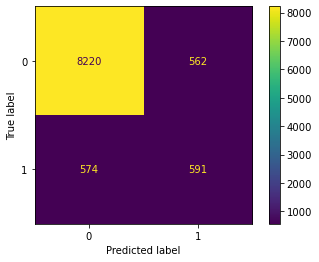

In [32]:
y_pred_train = clf_balanced_class.predict(X_train_preprocessed)
y_pred_test = clf_balanced_class.predict(X_test_preprocessed)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

The class_weight = 'balanced' model:

- predicted true positives 591 times (5.9% of all predictions, the baseline was 6%)
- predicted false positives 562 times (5.7%, baseline was 6%)
- predicted true negatives 8,220 times (85.6%, baseline was 82.3%)
- predicted false negatives 574 times (5.8%, baseline was 5.7%)

So, this model predicted three fewer true positives than the baseline, but also 32 fewer false ones. It did much beter with true negatives, but worse with false ones, which means the recall actually worsened. Let's check to be sure:

In [33]:
print("balanced training recall score:", recall_score(y_train, y_pred_train))
print("balanced test recall score:", recall_score(y_test, y_pred_test))

balanced training recall score: 1.0
balanced test recall score: 0.5072961373390558


That's a pretty slight decline from the baseline score of 0.51502; let's keep checking evaluation metrics with the AUC: 

In [34]:
#calculate train auc
fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
print('baseline training AUC:', auc(fpr, tpr))
#calculate test auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
print('baseline test AUC:', auc(fpr, tpr))

baseline training AUC: 1.0
baseline test AUC: 0.7216508015322016


This is a slight reduction compared to the baseline's 0.72369. There's definitely more to improve upon here.

### Further improvement of the class imbalance problem

Let's try over-sampling first. Specifically, we'll first over-sample the minority class (the "yes"/"1" class as opposed to the majority "no"/"0" class) via imblearn's RandomOverSampler tool. Let's at least try the "minority" sampling_strategy that completely balances yes and no answers before we attempt a more gradual approach. 

In [35]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority', random_state=713)
# fit and apply the transform
X_train_preprocessed_over, y_train_over = oversample.fit_resample(X_train_preprocessed, y_train)
#How does y_over look now?
y_train_over.value_counts()

0    35140
1    35140
Name: y, dtype: int64

In [36]:
len(y_train)/len(y_train_over)

0.5660927717700626

Ok, y_over is not only completely balanced, but also a *lot* bigger than it used to be. What's X_train like?

In [37]:
len(X_train_preprocessed_over)

70280

In [38]:
len(X_train_preprocessed)/len(X_train_preprocessed_over)

0.5660927717700626

Wow, this oversampled X_train is a lot bigger (and by the same amount as y_over is than y_train). So, X_over & y_over are a synthetic training dataset that may or may not result in better results. If I had to guess, I'd bet the training scores will still be way overfit and the test scores will because we oversampled too much here at the outset, but let's see. 

In [39]:
#fit the model to X_over & y_over
clf_oversample_minority = DecisionTreeClassifier(criterion='entropy', random_state=713)
clf_oversample_minority.fit(X_train_preprocessed_over, y_train_over)

DecisionTreeClassifier(criterion='entropy', random_state=713)

In [40]:
#make predictions for our evaluation metrics
#Remember, we can't do any oversampling with the test set
y_pred_train_over = clf_oversample_minority.predict(X_train_preprocessed)
y_pred_test_over = clf_oversample_minority.predict(X_test_preprocessed)

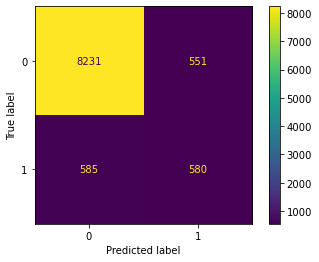

In [41]:
#confusion matrix for this new oversampling model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_over);

The oversampling with RandomOverSampler(sampling_strategy='minority') model:

- predicted true positives 580 times (6.6% of all predictions, the baseline had 6%)
- predicted false positives 551 times (5.5%, baseline was 6%)
- predicted true negatives 8,231 times (82.7%, baseline was 82.3%)
- predicted false negatives 585 times (5.9%, baseline was 5.7%)

This shows some improvement over baseline (except for false negatives), but let's check other metrics to see how this latest model performed.

In [42]:
print("oversampling minority recall score:", recall_score(y_train, y_pred_train_over))
print("oversampling minority recall score:", recall_score(y_test, y_pred_test_over))

oversampling minority recall score: 1.0
oversampling minority recall score: 0.4978540772532189


In [43]:
#calculate train auc
fpr, tpr, thresholds = roc_curve(y_train, y_pred_train_over)
print('oversampling minority training AUC:', auc(fpr, tpr))
#calculate test auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over)
print('baseline test AUC:', auc(fpr, tpr))

oversampling minority training AUC: 1.0
baseline test AUC: 0.7175560525186614


The recall and AUC scores have actually worsened, so hopefully iterating through a series of oversampling strategies will help.

### iterative oversampling strategies

The maximum we should oversample to is time-and-a-half (150%) of the minority class size, so let's try iterating through several more subtle sample_strategy params from there down to 110% and see whether we can find a better result along the way. 

The following dictionaries for our next iteration attempt will reflect 150% oversampling down to 110%, moving in 10% increments (so 150%, 140%, 130%, 120%, and 110%):

In [44]:
sampling_strategies = [{0:35140, 1:6968}, {0:35140, 1:6503}, {0:35140, 1:6039}, {0:35140, 1:5574}, {0:35140, 1:5156}]

In [45]:
recall_scores = []
auc_scores = []

sampling_strategies = sampling_strategies
for i in sampling_strategies:
    # define oversampling strategy
    oversample = RandomOverSampler(random_state=713, sampling_strategy=i)
    # fit and apply the transform
    X_train_preprocessed_over, y_train_over = oversample.fit_resample(X_train_preprocessed, y_train)    
    #instantiate & fit the model to X_over & y_over
    clf_oversample_temp = DecisionTreeClassifier(criterion='entropy', random_state=713)
    clf_oversample_temp.fit(X_train_preprocessed_over, y_train_over)
    #make predictions for our evaluation metrics
    y_pred_test_over = clf_oversample_temp.predict(X_test_preprocessed)
    #find & append recall scores
    recall_scores.append(recall_score(y_test, y_pred_test_over))
    #find & append auc scores
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over)
    auc_scores.append(auc(fpr,tpr))

print("Recall & AUC scores for 1.5 down through 1.1 sample_strategy dictionaries:")
print("recall scores:", recall_scores)
print("auc_scores:   ", auc_scores)

Recall & AUC scores for 1.5 down through 1.1 sample_strategy dictionaries:
recall scores: [0.5210300429184549, 0.5218884120171674, 0.5253218884120172, 0.527038626609442, 0.5236051502145923]
auc_scores:    [0.7271513229850758, 0.726840357226985, 0.7299235267612352, 0.7286753142156752, 0.7292359615796259]


In [46]:
print('maximum recall score:', max(recall_scores))
print('maximum AUC score:', max(auc_scores))

maximum recall score: 0.527038626609442
maximum AUC score: 0.7299235267612352


When we oversample the minority class in our target ("yes", aka "1") by 120%, we achieve the best recall score among these, which is also the best we've seen so far, even if it's a small improvement. 

The highest AUC score appears at the 130% oversampling rate, but since recall is prioritized, let's position the 120% oversampling model as our best so far and check the other evaluation metrics:

In [47]:
#Set oversampling to 120%
oversample = RandomOverSampler(random_state=713, sampling_strategy={0:35140, 1:5574})
# fit and apply the transform
X_train_preprocessed_over, y_train_over = oversample.fit_resample(X_train_preprocessed, y_train)    
#instantiate & fit the model to X_over & y_over
clf_oversample_120 = DecisionTreeClassifier(criterion='entropy', random_state=713)
clf_oversample_120.fit(X_train_preprocessed_over, y_train_over)

#make predictions for our evaluation metrics
y_pred_test_over = clf_oversample_120.predict(X_test_preprocessed)

#confirming recall score
print('recall score when oversampling at 120%:', recall_score(y_test, y_pred_test_over))
#confirming auc score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over)
print('AUC score when oversampling at 120%', auc(fpr, tpr))

recall score when oversampling at 120%: 0.527038626609442
AUC score when oversampling at 120% 0.7286753142156752


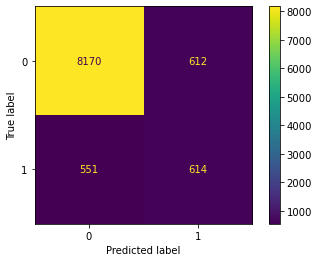

In [48]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_over);

The oversampling at 120% model:

- predicted true positives 614 times (6.2% of all predictions, the baseline had 6%)
- predicted false positives 612 times (6.2%, baseline had 6%)
- predicted true negatives 8,170 times (82.1%, baseline had 82.3%)
- predicted false negatives 551 times (5.5%, baseline had 5.7%)

Definitely an improvement. Even if it's pretty slight, this would already help net more term deposits. Nonetheless, there's more to do to improve this model. Let's see whether undersampling will return better results.

### Undersampling 

First we'll try the blanket "majority" mode for the sampling_strategy param and then we'll take the same iterative approach we did above.

In [49]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(random_state=713, sampling_strategy='majority')
X_train_preprocessed_under, y_train_under = undersample.fit_resample(X_train_preprocessed, y_train)
len(X_train_preprocessed_under), len(y_train_under)

(9290, 9290)

In [50]:
len(X_train), len(y_train)

(39785, 39785)

In [51]:
y_train.value_counts()

0    35140
1     4645
Name: y, dtype: int64

In [52]:
y_train_under.value_counts()

0    4645
1    4645
Name: y, dtype: int64

Okay, so it "balanced" y_train's classes and X_train is the same size as y_train now. Let's fit them to a clf and see what happens:

In [53]:
clf_undersampled_majority = DecisionTreeClassifier(criterion='entropy', random_state=713)
clf_undersampled_majority.fit(X_train_preprocessed_under, y_train_under)

DecisionTreeClassifier(criterion='entropy', random_state=713)

In [54]:
#make predictions for the undersampling model
y_pred_train_under = clf_undersampled_majority.predict(X_train_preprocessed)
y_pred_test_under = clf_undersampled_majority.predict(X_test_preprocessed)

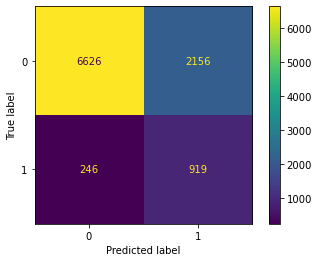

In [55]:
#confusion matrix for this undersampling model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_under);

We don't have to list every outcome here to see this model is unusable. It's great that the undersampling (strategy = 'majority') model has so few false negatives, but **I'm worried that 1,562 more wasted calls than the baseline's predictions just isn't worth the 319 more term deposits. Or maybe it is, I don't really know, only the stakeholder would.** 

If that is indeed the case, then this result is close, but not the lowest on false negatives. That would actually come towards the end of this notebook (when I fit SMOTE to the Scikit-Learn Logit model) - there is a result with only 214 false negatives and 1,476 false positives; no other model in this entire project results in fewer false negatives. However, I have a hunch that we'd want a more balanced model as our final one. 

To that end, let's attempt to refine training data undersampling ratios and see if we improve from here. Below, I layout undersampling strategies for less drastic ratios: 90%, 80%, 70%, 60%, and 50% of the majority, then iterate through them to see if we find an improved model.

In [56]:
sampling_strategies = [{0:31626, 1:4645}, {0:28112, 1:4645}, {0:24598, 1:4645}, {0:21084, 1:4645}, {0:17570, 1:4645}]

In [57]:
recall_scores = []
auc_scores = []

sampling_strategies = sampling_strategies
for i in sampling_strategies:
    # define undersampling strategy
    undersample = RandomUnderSampler(random_state=713, sampling_strategy=i)
    # fit and apply the transform
    X_train_preprocessed_under, y_train_under = undersample.fit_resample(X_train_preprocessed, y_train)    
    #instantiate & fit the model to X_over & y_over
    clf_undersample_float = DecisionTreeClassifier(criterion='entropy', random_state=713)
    clf_undersample_float.fit(X_train_preprocessed_under, y_train_under)
    #make predictions for our evaluation metrics
    y_pred_test_under = clf_undersample_float.predict(X_test_preprocessed)
    #find & append recall scores
    recall_scores.append(recall_score(y_test, y_pred_test_under))
    #find & append auc scores
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_under)
    auc_scores.append(auc(fpr, tpr))

print("Recall & AUC scores for 0.9 through 0.5 sample_strategy undersampling dictionaries:")
print("recall scores:", recall_scores)
print("auc_scores:   ", auc_scores)

Recall & AUC scores for 0.9 through 0.5 sample_strategy undersampling dictionaries:
recall scores: [0.5381974248927038, 0.5622317596566524, 0.5648068669527897, 0.5888412017167381, 0.6120171673819742]
auc_scores:    [0.7328882820204808, 0.7400660050845321, 0.7370834608050215, 0.7438057067567977, 0.7508958531056991]


In [58]:
print('max recall score:', max(recall_scores))
print('max AUC score:', max(auc_scores))

max recall score: 0.6120171673819742
max AUC score: 0.7508958531056991


It looks like the best recall and AUC pairing comes with an undersampling strategy of 50%. Let's evaluate more metrics with that specific model:

In [59]:
#Setting undersampling to 50%
undersample = RandomUnderSampler(random_state=713, sampling_strategy={0:17570, 1:4645})
# fit and apply the transform
X_train_preprocessed_under, y_train_under = undersample.fit_resample(X_train_preprocessed, y_train)    
#instantiate & fit the model to X_under & y_under
clf_undersample_50 = DecisionTreeClassifier(criterion='entropy', random_state=713)
clf_undersample_50.fit(X_train_preprocessed_under, y_train_under)

#make predictions for our evaluation metrics
y_pred_test_under = clf_undersample_50.predict(X_test_preprocessed)

#confirming recall score
print('recall score when undersampling at 50%:', recall_score(y_test, y_pred_test_under))
#confirming auc score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_under)
print('AUC score when undersampling at 50%', auc(fpr, tpr))

recall score when undersampling at 50%: 0.6120171673819742
AUC score when undersampling at 50% 0.7508958531056991


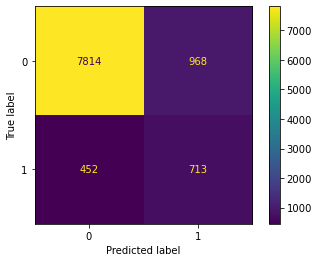

In [60]:
#confusion matrix for this undersampling model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_under);

This model with random undersampling at 50% of the majority class:

- predicted true positives 713 times (7.2% of all predictions, the baseline had 6%)
- predicted false positives 968 times (9.7%, baseline was 6%)
- predicted true negatives 7,814 times (78.6%, baseline was 82.3%)
- predicted false negatives 452 times (4.5%, baseline was 5.7%)

To review, our last best model (oversampling at 120%) predicted:

- predicted true positives 614 times (6.2%)
- predicted false positives 612 times (6.2%)
- predicted true negatives 8,170 times (82.1%)
- predicted false negatives 551 times (5.5%)

This model is predicting more true positives, but also a lot more false postives. It's a little lower on the true negatives than most other models, but it has a good amount of false negatives. **Compared to the last best model, it would result in 99 more term deposits, but at the expense of 356 more wasted call center calls.** Again, the stakeholder would know whether that's worth it because they know more about how much to expect from a typical term deposit. 

We can always present different options to the stakeholder: some that balance term deposits and call center costs (still with term deposits priveledged) and some that don't take call center costs into consideration.

For now, with recall being our important metric, let's priveldge this model as our current best even with its (substantial but not unwieldy) increased false postives.

### Trying to combine over & undersampling

In [61]:
#Oversample by 120% ('oversample' is still fit to 120% from before)
X_train_preprocessed_over_under, y_train_over_under = oversample.fit_resample(X_train_preprocessed, 
                                                                              y_train)
#Then fit undersampling by 50% to that same data
X_train_preprocessed_over_under, y_train_over_under = undersample.fit_resample(X_train_preprocessed_over_under, 
                                                                               y_train_over_under)
#instantiate & fit a model to the over & undersampled data
clf_over_under = DecisionTreeClassifier(criterion='entropy', random_state=713)
clf_over_under.fit(X_train_preprocessed_over_under, y_train_over_under)

#make predictions for our evaluation metrics
y_pred_test_over_under = clf_over_under.predict(X_test_preprocessed)

#confirming recall score
print('recall score when undersampling at 50% & oversampling at 120%:', recall_score(y_test, y_pred_test_over_under))
#confirming auc score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over_under)
print('AUC score when undersampling at 50% & oversampling at 120%:', auc(fpr, tpr))

recall score when undersampling at 50% & oversampling at 120%: 0.5965665236051502
AUC score when undersampling at 50% & oversampling at 120%: 0.7453340475005938


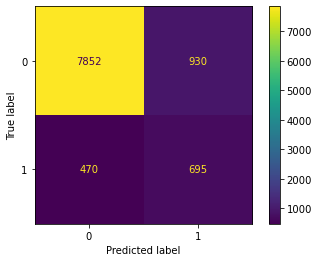

In [62]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_over_under);

Never mind, we can tell pretty quickly that it's not as good as previous models. Okay, let's move on to applying the SMOTE method to our training data.

### SMOTE

This is a different kind of oversampling technique that creates a synthetic dataset, let's see if it improves the model.

In [63]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=713)
X_train_preprocessed_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)
y_train_smote.value_counts()

0    35140
1    35140
Name: y, dtype: int64

In [64]:
clf_smote = DecisionTreeClassifier(criterion='entropy', random_state=713)
clf_smote.fit(X_train_preprocessed_smote, y_train_smote)

DecisionTreeClassifier(criterion='entropy', random_state=713)

In [65]:
y_pred_test_smote = clf_smote.predict(X_test_preprocessed)
#confirming recall score
print('recall score with SMOTE:', recall_score(y_test, y_pred_test_smote))
#confirming auc score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_smote)
print('AUC score with SMOTE:', auc(fpr, tpr))

recall score with SMOTE: 0.5055793991416309
AUC score with SMOTE: 0.7166362037839787


These scores don't compare to our current frontrunner model (undersampling at 50%), but to be sure, let's check out the SMOTE confusion matrix:

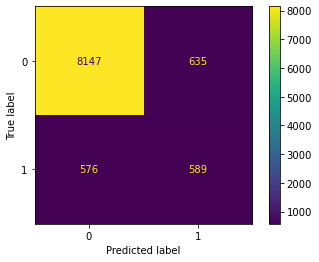

In [66]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_smote);

SMOTE is a definite improvement over the baseline, but it doesn't perform as well for our recall-oriented concerns, so our best decision tree model is still the undersampling-at-50% one.  

## Decision Tree Pruning

Next, we'll see whether tuning the model's 'max_depth', 'min_samples_split', and 'min_samples_leaf' hyperparameters help improve results. 

First, let's bring back the evaluation metrics for our best model:

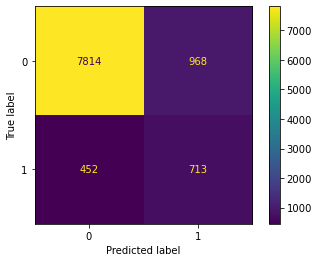

In [67]:
y_pred_test = clf_undersample_50.predict(X_test_preprocessed)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

In [68]:
print('recall:', recall_score(y_test, y_pred_test))

recall: 0.6120171673819742


In [69]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
print('AUC:', auc(fpr, tpr))

AUC: 0.7508958531056991


Great stuff, now let's try iterating through various modes for the model's 'max_depth' hyperparameter first:

best test score: 0.7705906932146617


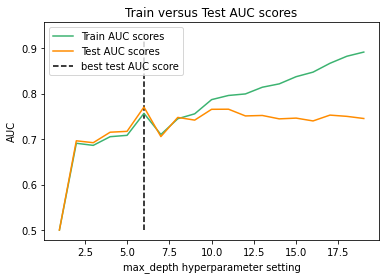

In [70]:
max_depth = np.arange(1,20)

#setup lists for plotting 
train_auc_values = []
test_auc_values = []

#iterating through max_values and filling the lists above
for i in max_depth:
    #initialize & train the classifier
    temp_clf = DecisionTreeClassifier(criterion="entropy", 
                                      random_state=713, 
                                      max_depth=i)
    temp_clf.fit(X_train_preprocessed_under, y_train_under)
    #calculate & append training AUC
    y_train_hat = temp_clf.predict(X_train_preprocessed)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_hat)
    train_roc_auc = auc(train_fpr, train_tpr)
    train_auc_values.append(train_roc_auc)
    #calculate & append AUC
    y_test_hat = temp_clf.predict(X_test_preprocessed)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_hat)
    test_roc_auc = auc(test_fpr, test_tpr)
    test_auc_values.append(test_roc_auc)
print("best test score:", max(test_auc_values))
#Plot
fig, ax = plt.subplots()
ax.plot(max_depth, train_auc_values, color='mediumseagreen', label='Train AUC scores')
ax.plot(max_depth, test_auc_values, color='darkorange', label='Test AUC scores')
ax.set_title('Train versus Test AUC scores')
ax.set_xlabel('max_depth hyperparameter setting')
ax.set_ylabel('AUC')
ax.vlines(6, ymin=0.5, ymax=0.935, color='k', linestyle='--', label="best test AUC score")
ax.legend();

Alright, we have an optimal max_depth setting of 6, which results in an improved AUC of 0.7706. That's a modest improvement over our best non-hyperparameter-optimized model (the undersampled by 50% model) AUC of 0.75089. Before refining more hyperparams, let's stop for a second and evaluate this model with max_depth=6 in regards to recall:

In [71]:
clf_undersample_50_md_6 = DecisionTreeClassifier(criterion='entropy', 
                                                  random_state=713, 
                                                  max_depth=6)
clf_undersample_50_md_6.fit(X_train_preprocessed_under, y_train_under)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=713)

In [72]:
y_pred_test_undersample_50_md_6 = clf_undersample_50_md_6.predict(X_test_preprocessed)
recall_score(y_test, y_pred_test_undersample_50_md_6)

0.6214592274678111

That's the best recall score we've seen so far. We're starting to get into the "good" recall range. Okay, now let's move on to tuning the 'min_samples_splits' hyperparam.

best test AUC score: 0.7213882668704911


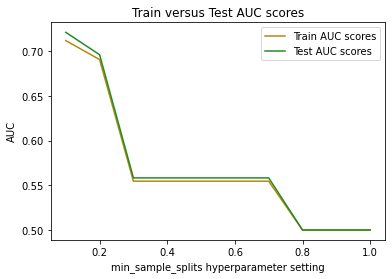

In [73]:
#I think we do this ratio with floats, at least at first
min_samples_split = np.arange(0.1,1.1,0.1)

#setup lists for plotting 
train_auc_values = []
test_auc_values = []

#iterating through max_values and filling the lists above
for i in min_samples_split:
    #initialize & train the classifier
    temp_clf = DecisionTreeClassifier(criterion='entropy', 
                                      random_state=713, 
                                      min_samples_split=i)
    temp_clf.fit(X_train_preprocessed_under, y_train_under)
    #calculate & append training AUC
    y_train_hat = temp_clf.predict(X_train_preprocessed)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_hat)
    train_roc_auc = auc(train_fpr, train_tpr)
    train_auc_values.append(train_roc_auc)
    #calculate & append AUC
    y_test_hat = temp_clf.predict(X_test_preprocessed)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_hat)
    test_roc_auc = auc(test_fpr, test_tpr)
    test_auc_values.append(test_roc_auc)
print("best test AUC score:", max(test_auc_values))
#Plot
fig, ax = plt.subplots()
ax.plot(min_samples_split, train_auc_values, color='darkgoldenrod', label='Train AUC scores')
ax.plot(min_samples_split, test_auc_values, color='forestgreen', label='Test AUC scores')
ax.set_title('Train versus Test AUC scores')
ax.set_xlabel('min_sample_splits hyperparameter setting')
ax.set_ylabel('AUC')
#ax.vlines(0.7, ymin=0.70, ymax=0.93, color='k', linestyle='--', label="my best guess")
ax.legend();

This doesn't help, so let's try adjusting 'min_samples_leaf' 

best test AUC score: 0.6398171054136289


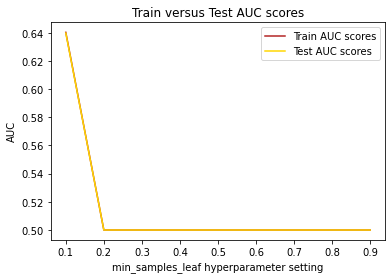

In [74]:
# Calculate the optimal value for minimum sample leafs
min_samples_leaf = np.arange(0.1,1.0,0.1)

#setup lists for plotting 
train_auc_values = []
test_auc_values = []

#iterating through max_values and filling the lists above
for i in min_samples_leaf:
    #initialize & train the classifier
    temp_clf = DecisionTreeClassifier(criterion='entropy', 
                                      random_state=713, 
                                      min_samples_leaf=i)
    temp_clf.fit(X_train_preprocessed_under, y_train_under)
    #calculate & append training AUC
    y_train_hat = temp_clf.predict(X_train_preprocessed)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_hat)
    train_roc_auc = auc(train_fpr, train_tpr)
    train_auc_values.append(train_roc_auc)
    #calculate & append AUC
    y_test_hat = temp_clf.predict(X_test_preprocessed)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_hat)
    test_roc_auc = auc(test_fpr, test_tpr)
    test_auc_values.append(test_roc_auc)
print("best test AUC score:", max(test_auc_values))
#Plot
fig, ax = plt.subplots()
ax.plot(min_samples_leaf, train_auc_values, color='firebrick', label='Train AUC scores')
ax.plot(min_samples_leaf, test_auc_values, color='gold', label='Test AUC scores')
ax.set_title('Train versus Test AUC scores')
ax.set_xlabel('min_samples_leaf hyperparameter setting')
ax.set_ylabel('AUC')
#ax.vlines(0.2, ymin=0.5, ymax=0.8, color='k', linestyle='--', label="my best guess")
ax.legend();

Tuning 'min_sample_leaf' along with 'min_samples_split' only worsens the model, so there we have it: **clf_undersample_50_md_6 is the best decision tree model**. One thing we haven't done yet is investigate its Confusion Matrix:

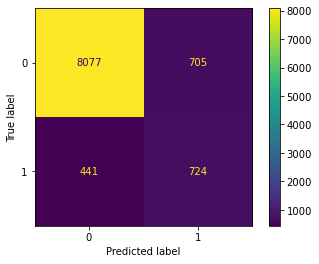

In [75]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_undersample_50_md_6);

This undersampling at 50% and max_depth=6 model:

- predicted true positives 724 times (7.3% of all predictions, the baseline had 6%)
- predicted false positives 705 times (7.1%, the baseline was 6%)
- predicted true negatives 8,077 times (81.2%, baseline was 82.3%)
- predicted false negatives 441 times (4.4%, baseline was 5.7%)

To review, our last best model (undersampling at 50%, but no max_depth specified) showed the following results:

- predicted true positives 713 times (7.2%)
- predicted false positives 968 times (9.7%)
- predicted true negatives 7,814 times (78.6%)
- predicted false negatives 452 times (4.5%)

Adding in the max_depth=6 param to our already-undersampled model improved the recall to 0.62146 (baseline was 0.51502, the AUC to 0.77059 (baseline was 0.72369). It only slightly increased the number of true positives and decreased false negatives by eleven compared to our last best model, **but it drastically improved on false postives by 263.** 

Again, while I may not know the specific financial gains & losses of term deposits versus wasted call center calls, I do know this model has best recall score without a ton of false positives. **Compared to our last best model, this is most likely to be the best decision tree model that balances those two concerns while still favoring more term deposits.**

Let's finally check the classification report for this model. First, let's bring back the baseline's report for quick reference, then this optimized model's:

In [76]:
print(classification_report(y_test, y_pred_test_baseline, target_names = target_names))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      8782
           1       0.50      0.52      0.51      1165

    accuracy                           0.88      9947
   macro avg       0.72      0.72      0.72      9947
weighted avg       0.88      0.88      0.88      9947



In [77]:
print(classification_report(y_test, y_pred_test_undersample_50_md_6, target_names=target_names))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      8782
           1       0.51      0.62      0.56      1165

    accuracy                           0.88      9947
   macro avg       0.73      0.77      0.75      9947
weighted avg       0.90      0.88      0.89      9947



While macro avg recall improved the most, it's enocuraging to see that other measurements stayed the same or improved slightly only slight execption (the individual "0" recall score). This optimization process had definitely resulted in a better model. 

Before moving on to Logit models, let's examine the revised tree model diagram:

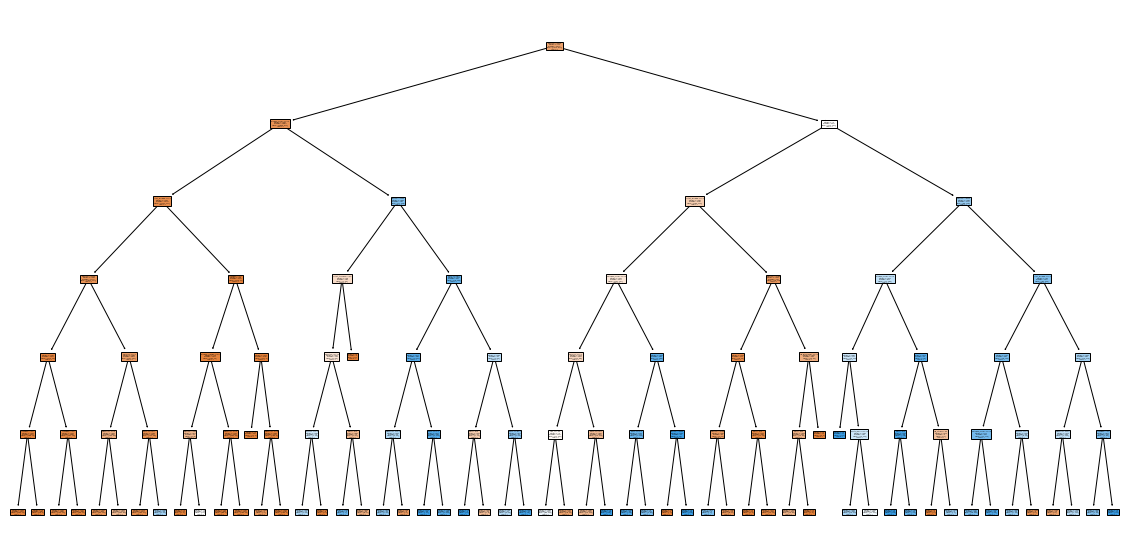

In [78]:
fig, ax = plt.subplots(figsize=(20,10))
tree.plot_tree(clf_undersample_50_md_6,
              feature_names = X_train_preprocessed_under.columns,
              class_names = np.unique(y).astype('str'),
              filled=True)
plt.show();

This looks *much* more reasonable than the Leviathan horror we saw in the baseline model's tree plot. This is still not easy to interpret, but we're more focused on predictions here, not necessarily a thorough understanding of how the model explains the data. 

However, we can still get a sense of the most important features that resulted in the first few splits:

In [79]:
#getting the feature names from our model
tree_feat_names = clf_undersample_50_md_6.feature_names_in_.tolist()
#getting the feature importances
tree_feat_imp = clf_undersample_50_md_6.feature_importances_.tolist()
#combining them into one list
tree_feat_names_importances = list(zip(tree_feat_names, tree_feat_imp))
#sorting the list by importance with a more concise name
tree_feats = sorted(tree_feat_names_importances, key = lambda x: x[1], reverse=True)
tree_feats

[('duration', 0.5381006930248052),
 ('poutcome_success', 0.22110895122210694),
 ('contact_unknown', 0.11145010585738607),
 ('housing_1', 0.051269612910691244),
 ('pdays', 0.02274997761000626),
 ('balance', 0.019775906574456454),
 ('campaign', 0.00992091830197969),
 ('age', 0.006256714820872472),
 ('loan_1', 0.005841326055068571),
 ('previous', 0.004435907971166607),
 ('poutcome_unknown', 0.0035947144662619485),
 ('marital_married', 0.0014744798102079254),
 ('education_2', 0.0012962497634182327),
 ('contact_telephone', 0.001180774967827298),
 ('job_entrepreneur', 0.001098174762257948),
 ('job_retired', 0.00044549188148711665),
 ('job_blue-collar', 0.0),
 ('job_housemaid', 0.0),
 ('job_management', 0.0),
 ('job_self-employed', 0.0),
 ('job_services', 0.0),
 ('job_student', 0.0),
 ('job_technician', 0.0),
 ('job_unemployed', 0.0),
 ('job_unknown', 0.0),
 ('marital_single', 0.0),
 ('education_1', 0.0),
 ('education_3', 0.0),
 ('default_1', 0.0),
 ('poutcome_other', 0.0)]

Let's see if we can improve on this optimized decision tree with logistic regression models from StatsModels and Scikit-Learn. 

## establishing a baseline StatsModels Logit model

Statistical significance still matters in logistic regression. It wasn't a real concern for our decision tree model, so let's see whether Logit models can help clear up which features matter the most for our marketing inquiry. Let's begin by fitting a StatsModels Logit model and see how it measures up. 

### normalizing features for Logit models

X_train_preprocessed is ready for a decision tree model, but not for the StatsModels & Scikit-Learn Logit models because its continuous features have not yet been normalized. Let's create a X_train_preprocessed_normalized for them.

In [80]:
columns_to_normalize = ['age', 'balance', 'campaign', 'pdays', 'previous']

#importing, instantiating, and fitting MinMaxScaler to X_train's continuous columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_preprocessed_normalized_columns = scaler.fit_transform(X_train[columns_to_normalize])

#new column names for normalized columns so I can drop their non-normalized counterparts
normalized_column_names = ['age_normalized', 'balance_normalized', 
                           'campaign_normalized', 'pdays_normalized', 'previous_normalized']

#Turning it back into a DataFrame
X_train_preprocessed_normalized_df = pd.DataFrame(X_train_preprocessed_normalized_columns,
                                      columns=normalized_column_names,
                                      index=X_train.index)
X_train_preprocessed_normalized = pd.concat([X_train_preprocessed_normalized_df, 
                                             X_train_preprocessed], axis=1).drop(columns_to_normalize, axis=1)
X_train_preprocessed_normalized.info()
X_train_preprocessed_normalized.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39785 entries, 22065 to 21197
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age_normalized       39785 non-null  float64
 1   balance_normalized   39785 non-null  float64
 2   campaign_normalized  39785 non-null  float64
 3   pdays_normalized     39785 non-null  float64
 4   previous_normalized  39785 non-null  float64
 5   duration             39785 non-null  int64  
 6   job_blue-collar      39785 non-null  float64
 7   job_entrepreneur     39785 non-null  float64
 8   job_housemaid        39785 non-null  float64
 9   job_management       39785 non-null  float64
 10  job_retired          39785 non-null  float64
 11  job_self-employed    39785 non-null  float64
 12  job_services         39785 non-null  float64
 13  job_student          39785 non-null  float64
 14  job_technician       39785 non-null  float64
 15  job_unemployed       39785 non-n

,age_normalized,balance_normalized,campaign_normalized,pdays_normalized,previous_normalized,duration,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,education_2,education_3,default_1,housing_1,loan_1,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
22065,0.428571,0.104452,0.161290,0.000000,0.000000,135,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23946,0.467532,0.077034,0.048387,0.000000,0.000000,436,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14232,0.220779,0.084488,0.016129,0.000000,0.000000,330,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
15211,0.415584,0.072976,0.048387,0.000000,0.000000,209,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
24198,0.207792,0.073757,0.000000,0.225917,0.007273,303,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
import statsmodels.api as sm
#adding the constant to X_train
X = sm.add_constant(X_train_preprocessed_normalized)
#y = np.asarray(y_train)
#instantiating & fitting the Logit model
logit_model = sm.Logit(y_train.astype(float), X.astype(float))
baseline_result = logit_model.fit(maxiter=3500)
#checking the results
baseline_result.summary()

Optimization terminated successfully.
         Current function value: 0.250707
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                39785
Model:                          Logit   Df Residuals:                    39754
Method:                           MLE   Df Model:                           30
Date:                Thu, 18 Jan 2024   Pseudo R-squ.:                  0.3044
Time:                        17:14:06   Log-Likelihood:                -9974.4
converged:                       True   LL-Null:                       -14339.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.5429      0.172    -14.763      0.000      -2.881      -2.205
age_normalized         -0.0072      0.176     -0.041      0.967      -0.353       0.339
balance_normalized      2.0030      0.554      3.617      0.000       0.918       3.089
campaign_normalized    -6.6697      0.645    -10.336      0.000      -7.934      -5.405
pdays_normalized        0.3173      0.277      1.144      0.253      -0.226       0.861
previous_normalized     1.9498      1.697      1.149      0.250      -1.376       5.275
duration                0.0041   6.67e-05     60.854      0.000       0.004       0.004
job_blue-collar        -0.3725      0.075     -4.962      0.000      -0.520      -0.225
job_entrepreneur       -0.5959      0.132     -4.512      0.000      -0.855      -0.337
job_housemaid          -0.5222      0.138     -3.781      0.000      -0.793      -0.252
job_management         -0.3183      0.076     -4.169      0.000      -0.468      -0.169
job_retired             0.3408      0.099      3.428      0.001       0.146       0.536
job_self-employed      -0.3594      0.113     -3.170      0.002      -0.582      -0.137
job_services           -0.3017      0.087     -3.456      0.001      -0.473      -0.131
job_student             0.4214      0.113      3.731      0.000       0.200       0.643
job_technician         -0.3400      0.072     -4.741      0.000      -0.481      -0.199
job_unemployed         -0.3408      0.120     -2.851      0.004      -0.575      -0.107
job_unknown            -0.2026      0.227     -0.892      0.372      -0.647       0.242
marital_married        -0.1854      0.061     -3.045      0.002      -0.305      -0.066
marital_single          0.1041      0.070      1.497      0.134      -0.032       0.240
education_1            -0.2106      0.108     -1.942      0.052      -0.423       0.002
education_2            -0.0336      0.096     -0.351      0.726      -0.221       0.154
education_3             0.2406      0.100      2.396      0.017       0.044       0.437
default_1              -0.0837      0.166     -0.505      0.614      -0.409       0.241
housing_1              -0.7637      0.042    -18.155      0.000      -0.846      -0.681
loan_1                 -0.6073      0.063     -9.686      0.000      -0.730      -0.484
contact_telephone      -0.0612      0.076     -0.803      0.422      -0.210       0.088
contact_unknown        -1.1810      0.062    -19.200      0.000      -1.302      -1.060
poutcome_other          0.2444      0.092      2.660      0.008       0.064       0.424
poutcome_success        2.2903      0.085     26.980      0.000       2.124       2.457
poutcome_unknown       -0.1910      0.096     -1.993      0.046      -0.379      -0.003
=======================================================================================
"""

Overall, this model has an acceptable p-value as do most of its attributes, but a few of them don't:

- 'age_normalized'
- 'pdays_normalized'
- 'previous_normalized'
- 'job_unknown'
- 'marital_single'
- 'education_1' 
- 'education_2'
- 'default_1'
- 'contact_telephone'

Will the model improve when we get rid of them? Let's run some metrics on this baseline first.

In [82]:
#normalizing X_test's continuous columns so we can run evaluation metrics
X_test_preprocessed_normalized_columns = scaler.transform(X_test[columns_to_normalize])

#new column names for normalized columns so I can drop their non-normalized counterparts
normalized_column_names = ['age_normalized', 'balance_normalized', 
                           'campaign_normalized', 'pdays_normalized', 'previous_normalized']

#Turning it back into a DataFrame
X_test_preprocessed_normalized_df = pd.DataFrame(X_test_preprocessed_normalized_columns,
                                      columns=normalized_column_names,
                                      index=X_test.index)
X_test_preprocessed_normalized = pd.concat([X_test_preprocessed_normalized_df, 
                                             X_test_preprocessed], axis=1).drop(columns_to_normalize, axis=1)

#making predictions
X_test_for_pred = sm.add_constant(X_test_preprocessed_normalized)
y_pred_test = round(baseline_result.predict(X_test_for_pred), 0).astype(int)

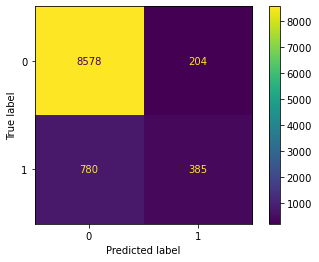

In [83]:
#building a confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

This StatsModels baseline:

- predicted true positives 385 times (3.9% of all predictions)
- predicted false positives 204 times (2.1%)
- predicted true negatives 8,578 times (86.2%)
- predicted false negatives 780 times (7.8%)

Overall, these results aren't good: too few true positives and too many false negatives. However, we know there are a few columns with unacceptable p-values. This didn't matter for a decision tree model, but it may matter for our Logit model here.

Let's check out some evaluation metrics before we start refining this model.

In [84]:
print('recall score:', recall_score(y_test, y_pred_test))

recall score: 0.33047210300429186


Oof, not great. What about AUC?

In [85]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
print('test AUC:', auc(fpr, tpr))

test AUC: 0.6536213851391306


Kind of meh. Now let's drop the bad columns and see whether that helps:

In [86]:
columns_to_drop = ['age_normalized', 'pdays_normalized', 'previous_normalized',
                   'job_unknown', 'marital_single', 'education_1', 'education_2', 'default_1', 'contact_telephone']
X_train_preprocessed_normalized_with_acceptable_pvals = X_train_preprocessed_normalized.drop(columns_to_drop, axis=1)

In [87]:
#adding the constant to X_train
X = sm.add_constant(X_train_preprocessed_normalized_with_acceptable_pvals)
#y = np.asarray(y_train)
#instantiating & fitting the Logit model
logit_model = sm.Logit(y_train.astype(float), X.astype(float))
selective_result = logit_model.fit(maxiter=3500)
#checking the results
selective_result.summary()

Optimization terminated successfully.
         Current function value: 0.250896
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                39785
Model:                          Logit   Df Residuals:                    39763
Method:                           MLE   Df Model:                           21
Date:                Thu, 18 Jan 2024   Pseudo R-squ.:                  0.3038
Time:                        17:14:07   Log-Likelihood:                -9981.9
converged:                       True   LL-Null:                       -14339.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.4188      0.093    -26.117      0.000      -2.600      -2.237
balance_normalized      1.9897      0.551      3.609      0.000       0.909       3.070
campaign_normalized    -6.7391      0.644    -10.458      0.000      -8.002      -5.476
duration                0.0041   6.67e-05     60.893      0.000       0.004       0.004
job_blue-collar        -0.4108      0.071     -5.750      0.000      -0.551      -0.271
job_entrepreneur       -0.6138      0.131     -4.689      0.000      -0.870      -0.357
job_housemaid          -0.6011      0.134     -4.474      0.000      -0.864      -0.338
job_management         -0.3218      0.075     -4.318      0.000      -0.468      -0.176
job_retired             0.2740      0.085      3.211      0.001       0.107       0.441
job_self-employed      -0.3635      0.112     -3.239      0.001      -0.583      -0.144
job_services           -0.2943      0.086     -3.411      0.001      -0.463      -0.125
job_student             0.4561      0.108      4.229      0.000       0.245       0.668
job_technician         -0.3262      0.070     -4.632      0.000      -0.464      -0.188
job_unemployed         -0.3589      0.118     -3.038      0.002      -0.590      -0.127
marital_married        -0.2670      0.039     -6.814      0.000      -0.344      -0.190
education_3             0.3010      0.052      5.832      0.000       0.200       0.402
housing_1              -0.7531      0.041    -18.320      0.000      -0.834      -0.673
loan_1                 -0.6071      0.062     -9.729      0.000      -0.729      -0.485
contact_unknown        -1.1812      0.061    -19.316      0.000      -1.301      -1.061
poutcome_other          0.2418      0.091      2.644      0.008       0.063       0.421
poutcome_success        2.2704      0.082     27.688      0.000       2.110       2.431
poutcome_unknown       -0.2989      0.058     -5.155      0.000      -0.413      -0.185
=======================================================================================
"""

There are only slight differences between this model and the previous with all the features. Overall, removing them improved all but one attribute's standard error a little. 15 out the 21 total attribute coefficients (includes one-hot encoded features, but not the features that weren't statistically significant) took on a slightly more negative slope, while the other 6 went slightly more positive:

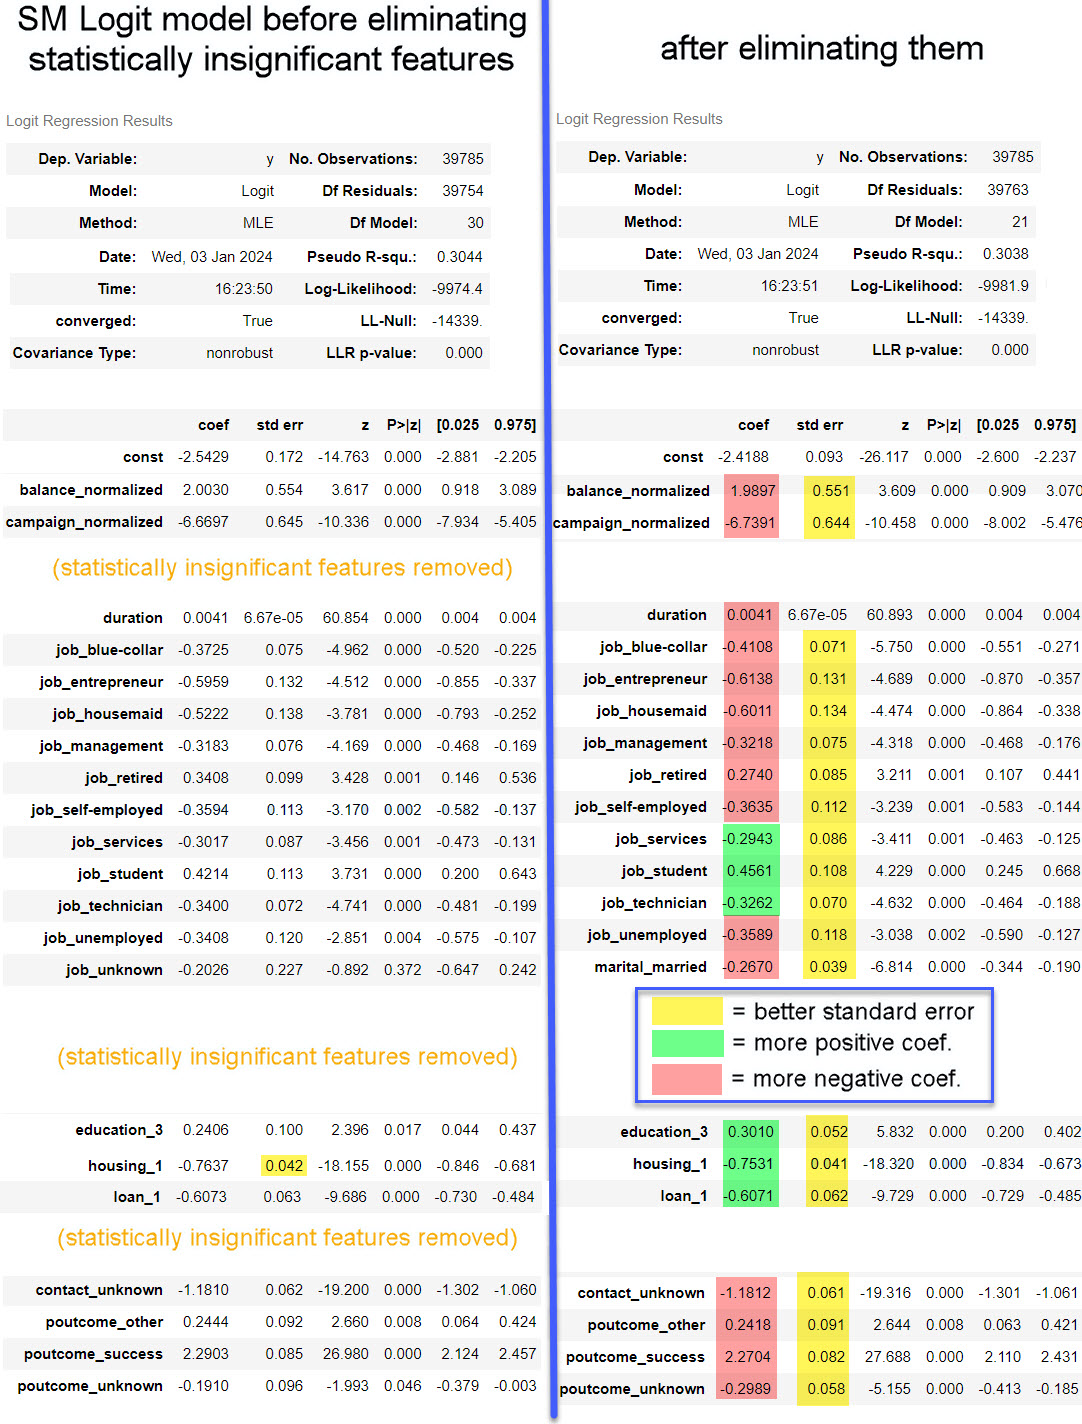

Overall, this more selective model does perform a little better, but not by much. Let's evaluate it a little more closely before deciding whether it's a real improvement.

In [88]:
#first, X_test needs to have the same features as our more selective model
X_test_preprocessed_normalized_with_acceptable_pvals = X_test_preprocessed_normalized.drop(columns_to_drop, axis=1)
#making predictions
X_test_preprocessed_normalized_with_acceptable_pvals = sm.add_constant(X_test_preprocessed_normalized_with_acceptable_pvals)
y_pred_test = round(selective_result.predict(X_test_preprocessed_normalized_with_acceptable_pvals), 0).astype(int)

In [89]:
print('recall score:', recall_score(y_test, y_pred_test))

recall score: 0.33047210300429186


In [90]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
print('test AUC:', auc(fpr, tpr))

test AUC: 0.6534505812220275


These are very slight improvements over the SM baseline recall score of 0.3296 and the AUC of 0.6529, but they're improvements nonetheless, se let's use this model as we proceed to address the class-imbalance problem here. 

Unlike decision trees, [there are no hyperparams for SM Logit for weighing classes](https://stackoverflow.com/questions/33605979/statsmodels-logistic-regression-class-imbalance), but maybe I can feed it the under/over sampled training data from the decision tree models.

In [91]:
#over-sampling strategies representing an over-sampling of the minority class ("1") at levels of 
# 150%, 140%, 130%, 120%, and 110%, respectively.
sampling_strategies = [{0:35140, 1:6968}, {0:35140, 1:6503}, {0:35140, 1:6039}, {0:35140, 1:5574}, {0:35140, 1:5156}]

In [92]:
recall_scores = []
auc_scores = []

sampling_strategies = sampling_strategies
for i in sampling_strategies:
    # define oversampling strategy
    oversample = RandomOverSampler(random_state=713, sampling_strategy=i)
    # fit and apply the transform
    X_train_over, y_train_over = oversample.fit_resample(X_train_preprocessed_normalized_with_acceptable_pvals, y_train)   
    #adding the constant to X_train
    X = sm.add_constant(X_train_over)
    #instantiate & fit the model to X_over & y_over
    logit_model = sm.Logit(y_train_over.astype(float), X.astype(float))
    over_result = logit_model.fit(maxiter=3500)
    
    
    #make predictions for our evaluation metrics
    y_pred_test_over = round(over_result.predict(X_test_preprocessed_normalized_with_acceptable_pvals), 0).astype(int)
    #find & append recall scores
    recall_scores.append(recall_score(y_test, y_pred_test_over))
    #find & append auc scores
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over)
    auc_scores.append(auc(fpr, tpr))

print("Recall & AUC scores for 1.5 down through 1.1 sample_strategy dictionaries:")
print("recall scores:", recall_scores)
print("auc_scores:   ", auc_scores)

Optimization terminated successfully.
         Current function value: 0.304478
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.295033
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.286038
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274793
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.264757
         Iterations 8
Recall & AUC scores for 1.5 down through 1.1 sample_strategy dictionaries:
recall scores: [0.4248927038626609, 0.4051502145922747, 0.38540772532188844, 0.3708154506437768, 0.351931330472103]
auc_scores:    [0.6947966138306699, 0.686405669810371, 0.6779008565120032, 0.6717434119536352, 0.6631553714533142]


In [93]:
print('maximum recall score:', max(recall_scores))
print('maximum AUC score:', max(auc_scores))

maximum recall score: 0.4248927038626609
maximum AUC score: 0.6947966138306699


The oversampling at 150% (the highest we can legitimately go) resulted in an improved recall and AUC score. The maximum recall still isn't good and the AUC score is just okay; both are definitely lower than our optimized decision tree. 

Let's see whether undersampling can make more of an improvement:

In [94]:
#These represent undersampling of the majority class ("0") at 90%, 80%, 70%, 60%, and then 50% of its
# original records, respectively.
sampling_strategies = [{0:31626, 1:4645}, {0:28112, 1:4645}, {0:24598, 1:4645}, {0:21084, 1:4645}, {0:17570, 1:4645}]

In [95]:
recall_scores = []
auc_scores = []

sampling_strategies = sampling_strategies
for i in sampling_strategies:
    # define undersampling strategy
    undersample = RandomUnderSampler(random_state=713, sampling_strategy=i)
    # fit and apply the transform
    X_train_under, y_train_under = undersample.fit_resample(X_train_preprocessed_normalized_with_acceptable_pvals, y_train)   
    #adding the constant to X_train
    X = sm.add_constant(X_train_under)
    #instantiate & fit the model to X_over & y_over
    logit_model = sm.Logit(y_train_under.astype(float), X.astype(float))
    under_result = logit_model.fit(maxiter=3500)
        
    #make predictions for our evaluation metrics
    y_pred_test_under = round(under_result.predict(X_test_preprocessed_normalized_with_acceptable_pvals), 0).astype(int)
    #find & append recall scores
    recall_scores.append(recall_score(y_test, y_pred_test_over))
    #find & append auc scores
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over)
    auc_scores.append(auc(fpr, tpr))

print("Recall & AUC scores for 0.9 through 0.5 sample_strategy undersampling dictionaries:")
print("recall scores:", recall_scores)
print("auc_scores:   ", auc_scores)

Optimization terminated successfully.
         Current function value: 0.264200
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.279289
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.296651
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.316566
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339186
         Iterations 7
Recall & AUC scores for 0.9 through 0.5 sample_strategy undersampling dictionaries:
recall scores: [0.351931330472103, 0.351931330472103, 0.351931330472103, 0.351931330472103, 0.351931330472103]
auc_scores:    [0.6631553714533142, 0.6631553714533142, 0.6631553714533142, 0.6631553714533142, 0.6631553714533142]


In [96]:
print('max recall score:', max(recall_scores))
print('max AUC score:', max(auc_scores))

max recall score: 0.351931330472103
max AUC score: 0.6631553714533142


Not good, it seems that StatsModels' Logit model - at least when it comes to this dataset - is not returning results that were as helpful as the decision tree model did. Nonetheless, let's at least double check the confusion matrix for the best optimized StatsModels Logit we found so far, when it's oversampled at 150%:

Optimization terminated successfully.
         Current function value: 0.304478
         Iterations 8


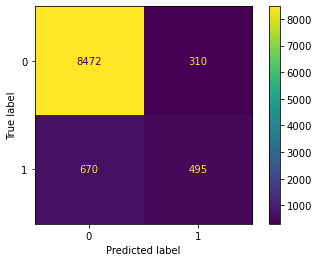

In [97]:
#setting oversampling strategy to 150% of minority class
oversample = RandomOverSampler(random_state=713, sampling_strategy={0:35140, 1:6968})
# fit and apply the transform
X_train_over, y_train_over = oversample.fit_resample(X_train_preprocessed_normalized_with_acceptable_pvals, y_train)   
#adding the constant to X_train
X = sm.add_constant(X_train_over)
#instantiate & fit the model to X_over & y_over
logit_model = sm.Logit(y_train_over.astype(float), X.astype(float))
over_at_150_result = logit_model.fit(maxiter=3500)
#make predictions for our evaluation metrics
y_pred_test_over = round(over_at_150_result.predict(X_test_preprocessed_normalized_with_acceptable_pvals), 0).astype(int)
#building a confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_over);

This 150%-oversampled StatsModels model:

- predicted true positives 495 times (5.0% of all predictions, the baseline was 3.9%)
- predicted false positives 310 times (3.1%, baseline was 2.1%)
- predicted true negatives 8,472 times (85.2%, baseline was 86.2%)
- predicted false negatives 670 times (6.7%, baseline was 7.8%)

Our optimized decision tree model (undersampling at 50% and max_depth=6):

- predicted true positives 724 times (7.3%)
- predicted false positives 705 times (7.1%)
- predicted true negatives 8,077 times (81.2%)
- predicted false negatives 441 times (4.4%)

So, even though our best StatsModels Logit model results in fewer wasted call center calls (false positives), it also results in fewer true positives, so this won't work for our ultimate final model. However, this model does help point out which features have the strongest coefficients with our target. 

Our current model coefficients are "log-odds", which aren't as easy to interpret, so let's "un-log" them and then examine the resulting odds:

In [98]:
#gathering the coefficients' names and values
logit_coef_names = over_at_150_result.params.index.to_list()
logit_coef_values = list(over_at_150_result.params.values)

In [99]:
import math 
#un-logging coefficients
logit_coef_values_odds = []
for i in logit_coef_values:
    logit_coef_values_odds.append(math.exp(i))
#adding their respective names
logit_coefs = zip(logit_coef_names, logit_coef_values_odds)
#sorting them by size
logit_coefs = sorted(logit_coefs, key = lambda x: x[1], reverse=True)
logit_coefs

[('poutcome_success', 9.685808673366552),
 ('balance_normalized', 8.273504712128254),
 ('job_student', 1.5138547108287321),
 ('job_retired', 1.3596006892198638),
 ('education_3', 1.3467656072783007),
 ('poutcome_other', 1.2362207281126572),
 ('duration', 1.0043217211771513),
 ('marital_married', 0.7685408992133848),
 ('job_management', 0.7285443141507254),
 ('job_technician', 0.7272776871418192),
 ('poutcome_unknown', 0.7234055027730549),
 ('job_services', 0.704984409401318),
 ('job_unemployed', 0.6929447564356066),
 ('job_self-employed', 0.6872272696894904),
 ('job_blue-collar', 0.6433304032645444),
 ('job_housemaid', 0.6042564566862844),
 ('job_entrepreneur', 0.5385493437114203),
 ('loan_1', 0.5376994534304816),
 ('housing_1', 0.47376622523107453),
 ('contact_unknown', 0.30497779597791447),
 ('const', 0.12466326704008447),
 ('campaign_normalized', 0.0007888070204520848)]

It'll help to visualize these:

In [100]:
#seperating & sorting the coefficient names for the plot below
logit_coef_names_sorted = [name[0] for name in logit_coefs]
#now the coefficient values
logit_coef_values_sorted = [value[1] for value in logit_coefs]

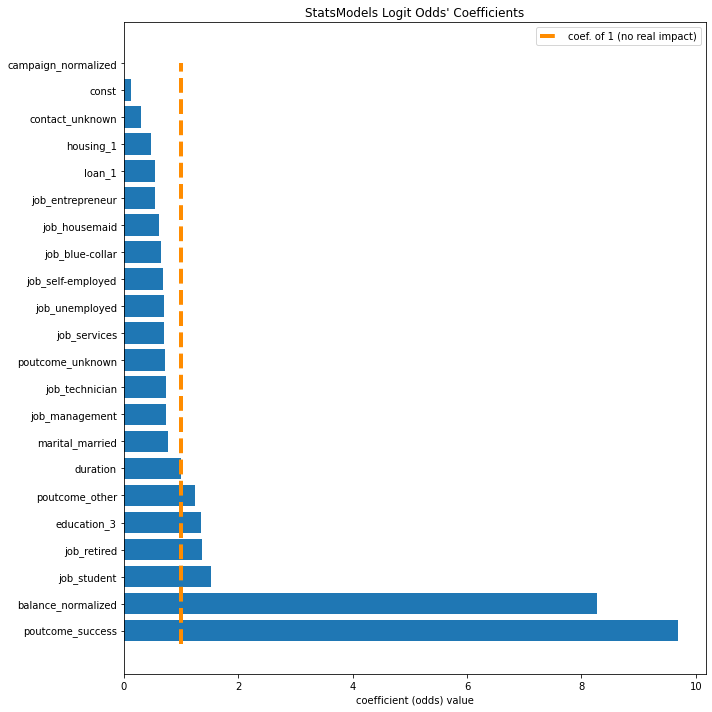

In [101]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(logit_coef_names_sorted, logit_coef_values_sorted)
#coefficients around 1 had little to no real impact, so let's put 
# a dashed line there to show that boundary.
ax.vlines(1, 
          ymin=-0.5, 
          ymax=21, 
          linestyle='--', 
          lw=4,
          color='darkorange', 
          label='coef. of 1 (no real impact)')
ax.set_title("StatsModels Logit Odds' Coefficients")
ax.set_xlabel("coefficient (odds) value")
ax.legend()
plt.tight_layout()
plt.savefig('SM Logit coefficients');

Two positive correlations stand apart:

- **'poutcome_success' odds increase by 869%** (whether a client made a term deposit before)
- **'balance_normalized' odds increase by 727%**, which is normalized, so this coeffiient isn't as interpretable as non-normalized ones, but we *can* at least say it's important

One negative correlation stands apart:

- **'campaign_normalized' odds decrease by 0.07%** (the 'number of contacts performed during this campaign and for this client') - it looks like many repeated contact attempts definitely don't help 

The rest of the features' coefficients were much smaller, with odds between 30% and 151%. However, we can definitely suggest that future campaigns should:

- **not worry about contacting too many times**
- **focus escpecially on clients who were convinced before**
- **focus on clients with higher balances**

While I'm a little surprised at contact attempts correlation, the other two seem unsurprising. However, it *is* helpful to see that the data supports these three as head-and-shoulders above other attributes in terms of significance. 

## comparing StatsModels' coefficients to our decision tree feature importances

Even though our StatsModels model didn't *predict* as well as our decision tree, it was certainly helpful to see our features from a coefficient-oriented view as opposed to a feature-importance one. One more thing we can try in our ongoing modeling process would be to compare how the Logit and decision tree models' feature-evaluation measures up. 

Let's bring back our decision tree's feature importances for a quick comparison:

In [102]:
tree_feats

[('duration', 0.5381006930248052),
 ('poutcome_success', 0.22110895122210694),
 ('contact_unknown', 0.11145010585738607),
 ('housing_1', 0.051269612910691244),
 ('pdays', 0.02274997761000626),
 ('balance', 0.019775906574456454),
 ('campaign', 0.00992091830197969),
 ('age', 0.006256714820872472),
 ('loan_1', 0.005841326055068571),
 ('previous', 0.004435907971166607),
 ('poutcome_unknown', 0.0035947144662619485),
 ('marital_married', 0.0014744798102079254),
 ('education_2', 0.0012962497634182327),
 ('contact_telephone', 0.001180774967827298),
 ('job_entrepreneur', 0.001098174762257948),
 ('job_retired', 0.00044549188148711665),
 ('job_blue-collar', 0.0),
 ('job_housemaid', 0.0),
 ('job_management', 0.0),
 ('job_self-employed', 0.0),
 ('job_services', 0.0),
 ('job_student', 0.0),
 ('job_technician', 0.0),
 ('job_unemployed', 0.0),
 ('job_unknown', 0.0),
 ('marital_single', 0.0),
 ('education_1', 0.0),
 ('education_3', 0.0),
 ('default_1', 0.0),
 ('poutcome_other', 0.0)]

### pruning coefficients & feature importances

These are different feature measurements: **coefficients** show the impact of a feature on the target assuming others stay the same while tree **feature importances** track the entropy in each feature as we navgiate down through the tree model. 

Subsequently, these two lists don't make for the most intuitive comparison, but in an effort to pare them down a little, let's compare the decision tree's feature importances that are greater than 0.01 and odds-coefficients that are greater than 1.5 or less than 0.5:

In [103]:
important_logit_coefs = [(x, y) for x, y in logit_coefs if y > 1.5 or y < 0.5]
important_logit_coefs = sorted(important_logit_coefs, key = lambda x: abs(x[1]), reverse=True)
important_logit_coefs

[('poutcome_success', 9.685808673366552),
 ('balance_normalized', 8.273504712128254),
 ('job_student', 1.5138547108287321),
 ('housing_1', 0.47376622523107453),
 ('contact_unknown', 0.30497779597791447),
 ('const', 0.12466326704008447),
 ('campaign_normalized', 0.0007888070204520848)]

In [104]:
important_tree_feats = [(x, y) for x, y in tree_feats if y > 0.01]
important_tree_feats

[('duration', 0.5381006930248052),
 ('poutcome_success', 0.22110895122210694),
 ('contact_unknown', 0.11145010585738607),
 ('housing_1', 0.051269612910691244),
 ('pdays', 0.02274997761000626),
 ('balance', 0.019775906574456454)]

Both the decision tree & Logit model "agree" on these more important features:

- 'poutcome_success'
- 'balance'
- the unhelpful 'contact_unknown' column
- 'housing_1' (whether the client has a mortgage)

So, let's attempt to refine the decision tree model *further* by only including these columns since the StatsModels model "vouches" for them, too:

In [105]:
X_train_preprocessed_under_pruned_features = X_train_preprocessed_under[['poutcome_success', 'balance', 'housing_1']]
#fit the optimized decision tree model
clf_undersample_50_md_6_pruned = DecisionTreeClassifier(criterion='entropy', 
                                                  random_state=713, 
                                                  max_depth=6)
clf_undersample_50_md_6_pruned.fit(X_train_preprocessed_under_pruned_features, y_train_under)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=713)

In [106]:
#pruning X_test accordingly
X_test_preprocessed_pruned_features = X_test_preprocessed[['poutcome_success', 'balance', 'housing_1']]
#making predictions
y_pred_test_undersample_50_md_6_pruned = clf_undersample_50_md_6_pruned.predict(X_test_preprocessed_pruned_features)
#recall score
recall_score(y_test, y_pred_test_undersample_50_md_6_pruned)

0.19570815450643778

It's not looking good. What about the AUC?

In [107]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_undersample_50_md_6_pruned)
auc(fpr, tpr)

0.5905664434568172

Rough. Okay, last is the confusion matrix:

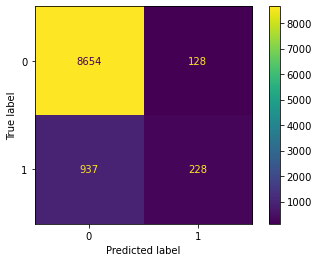

In [108]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_undersample_50_md_6_pruned);

That is the worst confusion matrix I have seen so far in this project. However, part of this poor predictive performance may be the existing hyperparameters and under-sampling strategy in place. Let's try this again, but without those in place:

In [109]:
#removing the undersampling strategy from X_train, but keeping just the wanted columns in place
X_train_preprocessed_pruned_features = X_train_preprocessed[['poutcome_success', 'balance', 'housing_1']]
#fit the optimized decision tree model
clf_pruned = DecisionTreeClassifier(criterion='entropy', random_state=713)
clf_pruned.fit(X_train_preprocessed_pruned_features, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=713)

In [110]:
#pruning X_test accordingly
X_test_preprocessed_pruned_features = X_test_preprocessed[['poutcome_success', 'balance', 'housing_1']]
#making predictions
y_pred_test_pruned = clf_pruned.predict(X_test_preprocessed_pruned_features)
#recall score
recall_score(y_test, y_pred_test_pruned)

0.19484978540772532

We are not off to a good start. Let's check the AUC.

In [111]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_pruned)
auc(fpr, tpr)

0.5824510826378185

Horrifying. Okay, last is the confusion matrix:

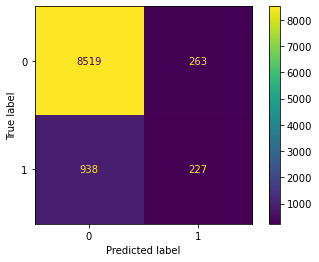

In [112]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_pruned);

Okay, this isn't going well. I suppose I can retry the over/under-sampling and hyperparameter tuning strategies again here. Let's start with re-doing the oversampling strategies from before:

In [113]:
sampling_strategies = [{0:35140, 1:6968}, {0:35140, 1:6503}, {0:35140, 1:6039}, {0:35140, 1:5574}, {0:35140, 1:5156}]

In [114]:
recall_scores = []
auc_scores = []

sampling_strategies = sampling_strategies
for i in sampling_strategies:
    # define oversampling strategy
    oversample = RandomOverSampler(random_state=713, sampling_strategy=i)
    # fit and apply the transform
    X_train_preprocessed_over, y_train_over = oversample.fit_resample(X_train_preprocessed_pruned_features, y_train)    
    #instantiate & fit the model to X_over & y_over
    clf_oversample_float = DecisionTreeClassifier(criterion='entropy', random_state=713)
    clf_oversample_float.fit(X_train_preprocessed_over, y_train_over)
    #make predictions for our evaluation metrics
    y_pred_test_over = clf_oversample_float.predict(X_test_preprocessed_pruned_features)
    #find & append recall scores
    recall_scores.append(recall_score(y_test, y_pred_test_over))
    #find & append auc scores
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over)
    auc_scores.append(auc(fpr, tpr))

print("Recall & AUC scores for 1.5 down through 1.1 sample_strategy dictionaries:")
print("recall scores:", recall_scores)
print("auc_scores:   ", auc_scores)

Recall & AUC scores for 1.5 down through 1.1 sample_strategy dictionaries:
recall scores: [0.2351931330472103, 0.23004291845493563, 0.22317596566523606, 0.21373390557939914, 0.20429184549356222]
auc_scores:    [0.5952212533830905, 0.5934432310334345, 0.5914331206144445, 0.5880785219083514, 0.5852932695926021]


In [115]:
print('maximum recall score:', max(recall_scores))
print('maximum AUC score:', max(auc_scores))

maximum recall score: 0.2351931330472103
maximum AUC score: 0.5952212533830905


Wow, this is surprisingly terrible. I wonder why, I thought it'd go better with just the all-around best features. Well, let's try undersampling as well to be thorough. 

In [116]:
sampling_strategies = [{0:31626, 1:4645}, {0:28112, 1:4645}, {0:24598, 1:4645}, {0:21084, 1:4645}, {0:17570, 1:4645}]

In [117]:
recall_scores = []
auc_scores = []

sampling_strategies = sampling_strategies
for i in sampling_strategies:
    # define undersampling strategy
    undersample = RandomUnderSampler(random_state=713, sampling_strategy=i)
    # fit and apply the transform
    X_train_preprocessed_under, y_train_under = undersample.fit_resample(X_train_preprocessed_pruned_features, y_train)    
    #instantiate & fit the model to X_over & y_over
    clf_undersample_float = DecisionTreeClassifier(criterion='entropy', random_state=713)
    clf_undersample_float.fit(X_train_preprocessed_under, y_train_under)
    #make predictions for our evaluation metrics
    y_pred_test_under = clf_undersample_float.predict(X_test_preprocessed_pruned_features)
    #find & append recall scores
    recall_scores.append(recall_score(y_test, y_pred_test_under))
    #find & append auc scores
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_under)
    auc_scores.append(auc(fpr, tpr))

print("Recall & AUC scores for 0.9 through 0.5 sample_strategy undersampling dictionaries:")
print("recall scores:", recall_scores)
print("auc_scores:   ", auc_scores)

Recall & AUC scores for 0.9 through 0.5 sample_strategy undersampling dictionaries:
recall scores: [0.2111587982832618, 0.2257510729613734, 0.24206008583690988, 0.2669527896995708, 0.2944206008583691]
auc_scores:    [0.5877588571238673, 0.5923790664283068, 0.5950109128797394, 0.6013652584343903, 0.6080962034125595]


In [118]:
print('max recall score:', max(recall_scores))
print('max AUC score:', max(auc_scores))

max recall score: 0.2944206008583691
max AUC score: 0.6080962034125595


Oversampling is also not going well with these pruned models. Okay, lastly let's see if SMOTE helps.

In [119]:
smote = SMOTE(random_state=713)
X_train_preprocessed_smote, y_train_smote = smote.fit_resample(X_train_preprocessed_pruned_features, y_train)
y_train_smote.value_counts()

0    35140
1    35140
Name: y, dtype: int64

In [120]:
clf_smote = DecisionTreeClassifier(criterion='entropy', random_state=713)
clf_smote.fit(X_train_preprocessed_smote, y_train_smote)

DecisionTreeClassifier(criterion='entropy', random_state=713)

In [121]:
y_pred_test_smote = clf_smote.predict(X_test_preprocessed_pruned_features)
#confirming recall score
print('recall score with SMOTE:', recall_score(y_test, y_pred_test_smote))
#confirming auc score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_smote)
print('AUC score with SMOTE:', auc(fpr, tpr))

recall score with SMOTE: 0.34334763948497854
AUC score with SMOTE: 0.5936733642653771


These scores don't compare to our current frontrunner model, but to be sure, let's check out the SMOTE confusion matrix:

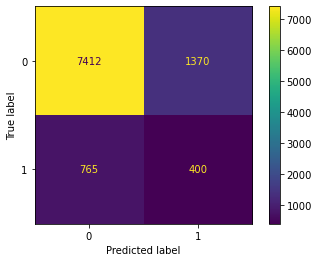

In [122]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_smote);

It looks like pruning features hasn't helped. It was worth a try, I suppose. I *could* try hyperparameter tuning here, but I get the feeling that if I put garbage in, I'm going to get garbage out. For the sake of concision and cutting our losses, let's move on to Logistic Regression with Scikit-Learn before we make a final call on the best model for our business problem.

## Logistic Regression model with Scikit-Learn

First, let's build a baseline model.

In [123]:
from sklearn.linear_model import LogisticRegression
#instantiate and fit the baseline model
logit_baseline_model = LogisticRegression(random_state=713, max_iter=2000)
logit_baseline_model.fit(X_train_preprocessed_normalized, y_train)

LogisticRegression(max_iter=2000, random_state=713)

In [124]:
#make predictions
y_pred_train_baseline = logit_baseline_model.predict(X_train_preprocessed_normalized)
y_pred_test_baseline = logit_baseline_model.predict(X_test_preprocessed_normalized)

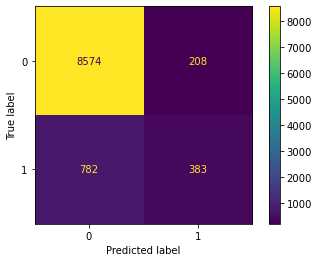

In [125]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_baseline);

This baseline Logistic Regression model:

- predicted true positives 383 times (3.9%, the decision tree baseline had 6%, the optimal one had 7.1%)
- predicted false positives 208 times (2.1%, the decision tree baseline had 6%, the optimal one had 6.4%)
- predicted true negatives 8,574 times (86.2%, the decision tree baseline had 82.3%, the optimal one had 81.9%)
- predicted false negatives 782 times (7.9%, the decision treebaseline had 5.7%, the optimal one had 4.6%)

This Scikit-Learn Logit baseline is off to a rough start. Even if it's doing a substantially better job with the true negatives/false positives, our focus on recall doesn't prioritize that strength as much as identifying true positives and avoiding false negatives.

Let's see what we can do to try and balance this model out. First things first: let's run the evaluation metrics here as we did with our previous models:

In [126]:
recall_score(y_test, y_pred_test_baseline)

0.32875536480686696

Terrible, as we expected from our confusion matrix. What about AUC?

In [127]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_baseline)
print('test AUC:', auc(fpr, tpr))

test AUC: 0.6525352774842806


Not great, not terrible, but definitely needs improvement. Ok, good to have a baseline. Now let's begin with the same steps we took for the decision tree and see whether under/over-sampling will help. When I started that process with decision trees, I just added a class_weight='balanced' hyperparam. I can do the same thing here, so let's try that first:

In [128]:
logit_baseline_model_balanced = LogisticRegression(random_state=713, class_weight="balanced", max_iter=2000)
logit_baseline_model_balanced.fit(X_train_preprocessed_normalized, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, random_state=713)

In [129]:
#make predictions
y_pred_train_balanced = logit_baseline_model_balanced.predict(X_train_preprocessed_normalized)
y_pred_test_balanced = logit_baseline_model_balanced.predict(X_test_preprocessed_normalized)

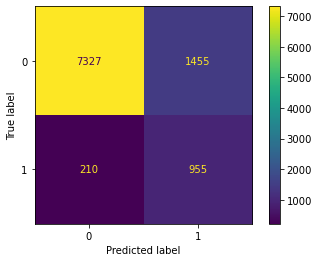

In [130]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_balanced);

This 'balanced' Logistic Regression model:

- predicted true positives 955 times (9.6%, this Scikit-Learn logit baseline had 3.9%, the optimal decision tree had 7.1%)
- predicted false positives 1,455 times (14.6%, logit baseline had 2.1%, optimal d.t. had 6.4%)
- predicted true negatives 7,327 times (73.7%, logit baseline had 86.2%, optimal d.t. had 81.9%)
- predicted false negatives 210 times (2.1%, logit baseline had 7.9%, optimal one had 4.6%)

On one hand, that is a terrible amount of false positives, but on the other hand, it's a great number of false negatives, which is more important for our stakeholder. 

Specifically, **this model has 252 fewer missed term deposits than our optimized decision tree model, but at the expense of a whopping 821 more unsuccesful calls. However, this is the model with the fewest false negatives in this entire project.** 

Again, it would be up to the stakeholder to determine whether that's worth it since they have an idea of what each term deposit gains them as opposed to what each wasted call center call costs, but that seems like a *lot* of wasted money on the call center.

Hopefully, we can improve on this model further and reduce the number of false positives without sacrificing (too many) false negatives. First, however, let's run the remaining evaluation metrics.

In [131]:
recall_score(y_test, y_pred_test_balanced)

0.8197424892703863

Wow, what an improvement. Ok now AUC:

In [132]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_balanced)
print('test AUC:', auc(fpr, tpr))

test AUC: 0.8270313448401578


Gracious, that's the best AUC we've seen so far, but we know it's coming at the expense of false positives. Next, let's try under & over-sampled inputs on the baseline model as opposed to the class_weight='balanced' parameter.  

In [133]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority', random_state=713)
# fit and apply the transform
X_train_preprocessed_normalized_over, y_train_over = oversample.fit_resample(X_train_preprocessed_normalized, y_train)
#instantiate and fit
logit_baseline_oversample_minority = LogisticRegression(random_state=713, max_iter=2000)
logit_baseline_oversample_minority.fit(X_train_preprocessed_normalized_over, y_train_over)

LogisticRegression(max_iter=2000, random_state=713)

In [134]:
#make predictions
y_pred_train_oversample_minority = logit_baseline_oversample_minority.predict(X_train_preprocessed_normalized_over)
y_pred_test_oversample_minority = logit_baseline_oversample_minority.predict(X_test_preprocessed_normalized)

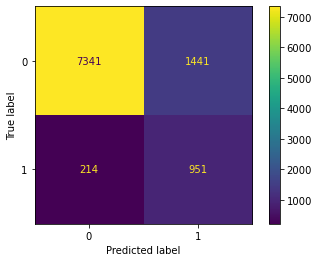

In [135]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_oversample_minority);

We can already see we have the same issue with the class_weight='balanced' model and this isn't even quite as good as that one, so let's try a more gradual approach to oversampling:

In [136]:
#over-sampling strategies representing an over-sampling of the minority class ("1") at levels of 
# 150%, 140%, 130%, 120%, and 110%, respectively.
sampling_strategies = [{0:35140, 1:6968}, {0:35140, 1:6503}, {0:35140, 1:6039}, {0:35140, 1:5574}, {0:35140, 1:5156}]

In [137]:
recall_scores = []
auc_scores = []

sampling_strategies = sampling_strategies
for i in sampling_strategies:
    # define oversampling strategy
    oversample = RandomOverSampler(random_state=713, sampling_strategy=i)
    # fit and apply the transform
    X_train_over, y_train_over = oversample.fit_resample(X_train_preprocessed_normalized, y_train)   
    #instantiate & fit the model to X_over & y_over
    temp_logit_oversample = LogisticRegression(random_state=713, max_iter=2000)
    temp_logit_oversample.fit(X_train_over, y_train_over)
        
    #make predictions for our evaluation metrics
    y_pred_test_over = temp_logit_oversample.predict(X_test_preprocessed_normalized)
    #find & append recall scores
    recall_scores.append(recall_score(y_test, y_pred_test_over))
    #find & append auc scores
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over)
    auc_scores.append(auc(fpr, tpr))

print("Recall & AUC scores for 1.5 down through 1.1 sample_strategy dictionaries:")
print("recall scores:", recall_scores)
print("auc_scores:   ", auc_scores)

Recall & AUC scores for 1.5 down through 1.1 sample_strategy dictionaries:
recall scores: [0.4223175965665236, 0.4008583690987124, 0.38626609442060084, 0.37339055793991416, 0.35278969957081546]
auc_scores:    [0.6935659948216357, 0.6845444202587618, 0.6779314985881186, 0.6726893577674975, 0.6634137520855672]


In [138]:
print('maximum recall score:', max(recall_scores))
print('maximum AUC score:', max(auc_scores))

maximum recall score: 0.4223175965665236
maximum AUC score: 0.6935659948216357


Each recall and AUC score above are an improvement over the baseline, which you love to see. It looks like the best overall performance comes when oversampling is set as high as it can legitimately go at 150%. Let's isolate it and run a confusion matrix:

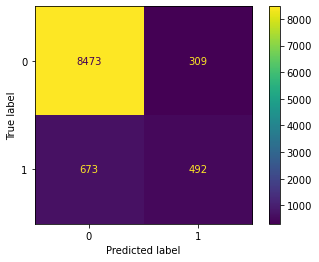

In [139]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy={0:35140, 1:6968}, random_state=713)
# fit and apply the transform
X_train_preprocessed_normalized_over, y_train_over = oversample.fit_resample(X_train_preprocessed_normalized, y_train)
#instantiate and fit
logit_oversample_150 = LogisticRegression(random_state=713, max_iter=2000)
logit_oversample_150.fit(X_train_preprocessed_normalized_over, y_train_over)
#make predictions
y_pred_test_oversample_150 = logit_oversample_150.predict(X_test_preprocessed_normalized)
#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_oversample_150);

This oversampled-at-150% Logistic Regression model:

- predicted true positives 492 times (5%, this Scikit-Learn logit baseline had 3.9%, the optimal decision tree had 7.1%)
- predicted false positives 309 times (3.1%, logit baseline had 2.1%, optimal d.t. had 6.4%)
- predicted true negatives 8,473 times (85.2%, logit baseline had 86.2%, optimal d.t. had 81.9%)
- predicted false negatives 673 times (6.8%, logit baseline had 7.9%, optimal one had 4.6%)

This is a substantial *overall* improvement over our baseline, but it's still pretty rough compared to our optimized decision tree. Let's see whether undersampling helps more:

In [140]:
#These represent undersampling of the majority class ("0") at 90%, 80%, 70%, 60%, and then 50% of its
# original records, respectively.
sampling_strategies = [{0:31626, 1:4645}, {0:28112, 1:4645}, {0:24598, 1:4645}, {0:21084, 1:4645}, {0:17570, 1:4645}]

In [141]:
recall_scores = []
auc_scores = []

sampling_strategies = sampling_strategies
for i in sampling_strategies:
    # define undersampling strategy
    undersample = RandomUnderSampler(random_state=713, sampling_strategy=i)
    # fit and apply the transform
    X_train_under, y_train_under = undersample.fit_resample(X_train_preprocessed_normalized, y_train)   
    #instantiate & fit the model to X_under & y_under
    temp_logit_undersample = LogisticRegression(random_state=713, max_iter=2000)
    temp_logit_undersample.fit(X_train_under, y_train_under)
        
    #make predictions for our evaluation metrics
    y_pred_test_under = temp_logit_undersample.predict(X_test_preprocessed_normalized)
    #find & append recall scores
    recall_scores.append(recall_score(y_test, y_pred_test_under))
    #find & append auc scores
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_under)
    auc_scores.append(auc(fpr, tpr))

print("Recall & AUC scores for 0.9 through 0.5 sample_strategy undersampling dictionaries:")
print("recall scores:", recall_scores)
print("auc_scores:   ", auc_scores)

Recall & AUC scores for 0.9 through 0.5 sample_strategy undersampling dictionaries:
recall scores: [0.3502145922746781, 0.3802575107296137, 0.41201716738197425, 0.4429184549356223, 0.49356223175965663]
auc_scores:    [0.6621261984374984, 0.6756104224110379, 0.6893267344539112, 0.702101450196119, 0.723722587070901]


In [142]:
print('max recall score:', max(recall_scores))
print('max AUC score:', max(auc_scores))

max recall score: 0.49356223175965663
max AUC score: 0.723722587070901


Undersampling at 50% has certainly led to an improved recall & AUC score. Let's isolate it and evaluate it further:  

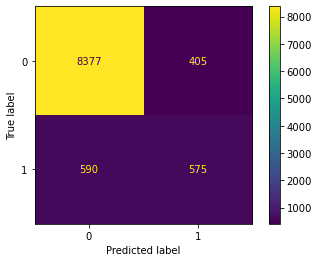

In [143]:
# setting undersampling to 50%
undersample = RandomUnderSampler(sampling_strategy={0:17570, 1:4645}, random_state=713)
# fit and apply the transform
X_train_preprocessed_normalized_under, y_train_under = undersample.fit_resample(X_train_preprocessed_normalized, y_train)
#instantiate and fit
logit_undersample_50 = LogisticRegression(random_state=713, max_iter=2000)
logit_undersample_50.fit(X_train_preprocessed_normalized_under, y_train_under)
#make predictions
y_pred_test_undersample_50 = logit_undersample_50.predict(X_test_preprocessed_normalized)
#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_undersample_50);

This undersampled-at-50% Logistic Regression model:

- predicted true positives 575 times (5.8%, this Scikit-Learn logit baseline had 3.9%, the optimal decision tree had 7.1%)
- predicted false positives 405 times (4.1%, logit baseline had 2.1%, optimal d.t. had 6.4%)
- predicted true negatives 8,377 times (84.2%, logit baseline had 86.2%, optimal d.t. had 81.9%)
- predicted false negatives 590 times (5.9%, logit baseline had 7.9%, optimal one had 4.6%)

Similar story to what we just saw: better than the baseline, but nowhere near our optimized decision tree. Let's try both under and oversampling:

recall score with over-and-under sampling: 0.5836909871244635
AUC score with over-and-under sampling: 0.7570584291122203


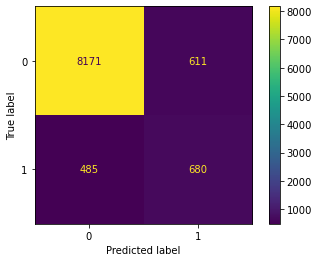

In [144]:
# setting undersampling to 50% and oversampling to 150%
undersample = RandomUnderSampler(sampling_strategy={0:17570, 1:4645}, random_state=713)
#adjusting oversampler to have as many majority records (class "0") as the undersampled
# set above will have
oversample = RandomOverSampler(sampling_strategy={0:17570, 1:6968}, random_state=713)
# fit and apply the transforms
X_train_over_and_under, y_train_over_and_under = undersample.fit_resample(X_train_preprocessed_normalized, y_train)
X_train_over_and_under, y_train_over_and_under = oversample.fit_resample(X_train_over_and_under, y_train_over_and_under)
#instantiate and fit the model
logit_over_and_under = LogisticRegression(random_state=713, max_iter=2000)
logit_over_and_under.fit(X_train_over_and_under, y_train_over_and_under)
#make predictions
y_pred_test_over_and_under = logit_over_and_under.predict(X_test_preprocessed_normalized)
#recall score
print('recall score with over-and-under sampling:', recall_score(y_test, y_pred_test_over_and_under))
#auc score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over_and_under)
print('AUC score with over-and-under sampling:', auc(fpr, tpr))
#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_over_and_under);

This undersampled-at-50%-and-oversampled-at-150% Logistic Regression model:

- predicted true positives 680 times (6.8%, this Scikit-Learn logit baseline had 3.9%, the optimal decision tree had 7.1%)
- predicted false positives 611 times (6.1%, logit baseline had 2.1%, optimal d.t. had 6.4%)
- predicted true negatives 8,171 times (82.2%, logit baseline had 86.2%, optimal d.t. had 81.9%)
- predicted false negatives 485 times (5.9%, logit baseline had 7.9%, optimal one had 4.6%)

Better than over & undersampling on their own. In fact, this model is coming close to the optimized decision tree results, but isn't quite there. Will applying SMOTE to our dataset help further?

recall score with SMOTE: 0.8171673819742489
AUC score with SMOTE: 0.824548163772367


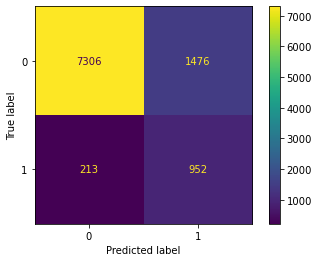

In [145]:
#instantiate and fit SMOTE
smote = SMOTE(random_state=713)
X_train_preprocessed_normalized_smote, y_train_smote = smote.fit_resample(X_train_preprocessed_normalized, y_train)
#instantiate and fit Logit model
logit_smote = LogisticRegression(random_state=713, max_iter=2000)
logit_smote.fit(X_train_preprocessed_normalized_smote, y_train_smote)
#transform X_test so we can make predictions
y_pred_test_smote = logit_smote.predict(X_test_preprocessed_normalized)
#recall score
print('recall score with SMOTE:', recall_score(y_test, y_pred_test_smote))
#auc score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_smote)
print('AUC score with SMOTE:', auc(fpr, tpr))
#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_smote);

Nope, the false positives are out of control again. This means the Logit model with over-and-under-sampling is best Logit so far, let's tune a few hyperparameters with that model:

In [146]:
C_params = [1, 10, 100, 1000, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12, 1e13, 1e14]

In [147]:
recall_scores = []
auc_scores = []

for i in C_params:
    #instantiate & fit the model to X_under & y_under
    temp_logit_over_and_under = LogisticRegression(random_state=713, max_iter=3000, C=i)
    temp_logit_over_and_under.fit(X_train_over_and_under, y_train_over_and_under)
        
    #make predictions for our evaluation metrics
    y_pred_test = temp_logit_over_and_under.predict(X_test_preprocessed_normalized)
    #find & append recall scores
    recall_scores.append(recall_score(y_test, y_pred_test))
    #find & append auc scores
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
    auc_scores.append(auc(fpr, tpr))

print("Recall & AUC scores for Logit model C params 1 through 1e14:")
print("recall scores:", recall_scores)
print("auc_scores:   ", auc_scores)

Recall & AUC scores for Logit model C params 1 through 1e14:
recall scores: [0.5836909871244635, 0.5896995708154507, 0.5871244635193134, 0.590557939914163, 0.5931330472103005, 0.5914163090128756, 0.5845493562231759, 0.590557939914163, 0.592274678111588, 0.5836909871244635, 0.5888412017167381, 0.590557939914163, 0.5879828326180258, 0.5914163090128756, 0.5888412017167381]
auc_scores:    [0.7570584291122203, 0.7596072438454388, 0.7582627555583358, 0.7598656244776918, 0.7614947859599668, 0.7601240051099449, 0.7573737443835077, 0.7598086898386575, 0.7607239935764043, 0.7569445598341515, 0.7588933861009106, 0.7596378859215542, 0.7585211361905888, 0.7603517436660825, 0.7591780592960825]


In [148]:
print('max recall score:', max(recall_scores))
print('max AUC score:', max(auc_scores))

max recall score: 0.5931330472103005
max AUC score: 0.7614947859599668


It looks like the optimal C param is 1e4 (10,000), let's visualize this:

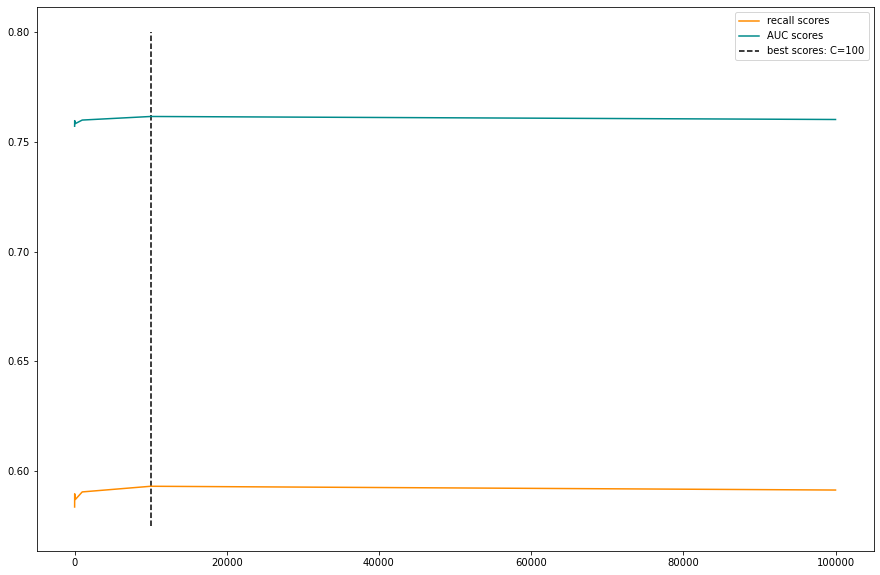

In [149]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(C_params[0:6], recall_scores[0:6], color="darkorange", label="recall scores")
ax.plot(C_params[0:6], auc_scores[0:6], color="darkcyan", label="AUC scores")
ax.vlines(1e4, ymin=0.575, ymax=0.8, color='k', linestyle='--', label="best scores: C=100")
plt.legend();

So when C=1e4, we get a maximum recall score of 0.5931 *and* maximum AUC score of 0.7615, which are both slight improvements, so we can proceed knowing we'll set C=1e4 from here on out. What about adjusting the model's regulator itself and the solver?

In [150]:
print("solver:", logit_over_and_under.get_params()["solver"])
print("penalty:", logit_over_and_under.get_params()["penalty"])

solver: lbfgs
penalty: l2


Let's try a different regularization technique, like l1 instad of l2:

recall score with over-and-under sampling, C1e4, and l1 penalty in the picture: 0.49699570815450644
AUC score with over-and-under sampling, C=1e4, and l1 penalty in the picture: 0.7186641032232336


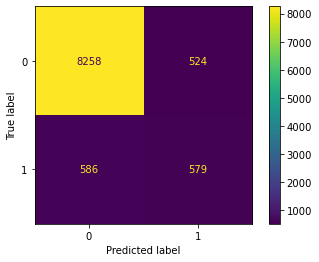

In [151]:
#instantiate and fit the model
logit_over_and_under = LogisticRegression(random_state=713, 
                                          max_iter=6000,
                                          C=1e4,
                                          solver="saga", 
                                          penalty="l1")
logit_over_and_under.fit(X_train_over_and_under, y_train_over_and_under)
#make predictions
y_pred_test_over_and_under = logit_over_and_under.predict(X_test_preprocessed_normalized)
#recall score
print('recall score with over-and-under sampling, C1e4, and l1 penalty in the picture:', recall_score(y_test, y_pred_test_over_and_under))
#1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over_and_under)
print('AUC score with over-and-under sampling, C=1e4, and l1 penalty in the picture:', auc(fpr, tpr))
#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_over_and_under);

The recall, AUC, and false negatives are not as good as our current front-running model. Let's try another penalty in the hyperparameters:

recall score with over-and-under sampling, C=1e4, and elasticnet penalty in the picture: 0.49699570815450644
AUC score with over-and-under sampling, C=1e4, and l1 penalty in the picture: 0.7186641032232336


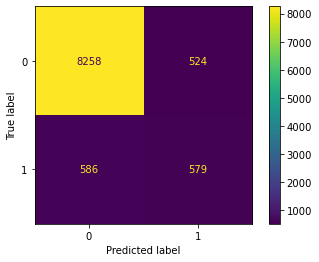

In [152]:
#instantiate and fit the model
logit_over_and_under = LogisticRegression(random_state=713, 
                                          max_iter=6000,
                                          C=1e4,
                                          solver="saga", 
                                          penalty="elasticnet",
                                          l1_ratio=0.5)
logit_over_and_under.fit(X_train_over_and_under, y_train_over_and_under)
#make predictions
y_pred_test_over_and_under = logit_over_and_under.predict(X_test_preprocessed_normalized)
#recall score
print('recall score with over-and-under sampling, C=1e4, and elasticnet penalty in the picture:', recall_score(y_test, y_pred_test_over_and_under))
#auc score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over_and_under)
print('AUC score with over-and-under sampling, C=1e4, and l1 penalty in the picture:', auc(fpr, tpr))
#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_over_and_under);

Neither of these hyperparameter changes improve the model over the over-and-under sampled one that used the "lbfgs" solver with L2 regularization.

That makes our best Scikit-Learn Logit model the over-at-150%-and-under-at-50%-sampled one, but we still haven't seen the confusion matrix there once we've set C=1e4: 

recall score with over-and-under sampling and C=1e4: 0.5931330472103005
AUC score with over-and-under sampling and C=1e4: 0.7614947859599668


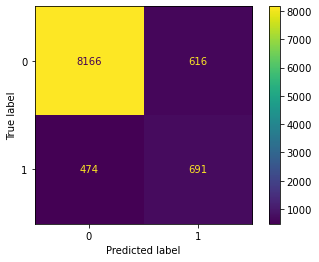

In [153]:
#instantiate and fit the model with C=1e4
logit_over_and_under_c1e4 = LogisticRegression(random_state=713, max_iter=2000, C=1e4)
logit_over_and_under_c1e4.fit(X_train_over_and_under, y_train_over_and_under)
#make predictions
y_pred_test_over_and_under_c1e4 = logit_over_and_under_c1e4.predict(X_test_preprocessed_normalized)
#recall score
print('recall score with over-and-under sampling and C=1e4:', recall_score(y_test, y_pred_test_over_and_under_c1e4))
#auc score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over_and_under_c1e4)
print('AUC score with over-and-under sampling and C=1e4:', auc(fpr, tpr))
#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_over_and_under_c1e4);

Adding C=10 into our best Scikit-Learn model:

- predicted true positives 691 times (6.9%, this Scikit-Learn logit baseline had 3.9%, the optimal decision tree had 7.1%)
- predicted false positives 616 times (6.2%, logit baseline had 2.1%, optimal d.t. had 6.4%)
- predicted true negatives 8,166 times (82.1%, logit baseline had 86.2%, optimal d.t. had 81.9%)
- predicted false negatives 474 times (4.8%, logit baseline had 7.9%, optimal d.t. had 4.6%)

The previous, default (C=1) undersampled-at-50%-and-oversampled-at-150% Logistic Regression model:

- predicted true positives 680 times (6.8%)
- predicted false positives 611 times (6.1%)
- predicted true negatives 8,171 times (82.2%)
- predicted false negatives 485 times (5.9%)

So, while this is the best we've done with the Scikit-Learn Logit so far, it's not performing *quite* as well as our optimized decision tree model did. Since it's somewhat close, let's also compare it's overall classification report to the optimized decision tree model:

In [154]:
#First, let's bring back the optimized decision tree report for quick reference:
print(classification_report(y_test, y_pred_test_undersample_50_md_6, target_names=target_names))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      8782
           1       0.51      0.62      0.56      1165

    accuracy                           0.88      9947
   macro avg       0.73      0.77      0.75      9947
weighted avg       0.90      0.88      0.89      9947



In [155]:
#Now let's check out optimized Scikit-Learn Logit report:
print(classification_report(y_test, y_pred_test_over_and_under_c1e4, target_names=target_names))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      8782
           1       0.53      0.59      0.56      1165

    accuracy                           0.89      9947
   macro avg       0.74      0.76      0.75      9947
weighted avg       0.90      0.89      0.89      9947



Pretty close; if we weren't prioritizing missed term deposits so much, it would be difficult to choose which model works best. 

## Summary

Tailoring model evaluation to the stakeholder's needs, we evaluated three different kinds of classification models. In this case, we were concerned with maximizing true positives and minimizing false negatives, but not to the extent where false positives were ignored. Indeed, a number of models with low false negatives were discarded in favor of at least somewhat more balanced models.

### Recommendations

**The decision tree model optimized with 50%-majority-class-under-sampled data and a max_depth parameter setting of 6 gave us our best overall results: when trained on new data, it should result in predictions that maximize the probability of the most term deposits while minimizing wasted call center costs.** 

We then tried out to logistic regression models: one with Scikit-Learn and one with StatsModels. The Scikit-Learn model optimized with over-and-under-sampled data came close, but didn't quite measure up to the results of our final decision tree. **The best StatsModels iteration didn't come quite as close, but did offer some helpful insight into the data's strongest features through its emphasis on statistical significance: 

1. **'poutcome_success' increases successful outcome odds by 869%** (whether a client made a term deposit before)
2. **'balance_normalized' increases successful outcome odds by 727%** (this feature was normalized, so this coefficient isn't as interpretable as the other two, non-normalized ones, but we *can* at least say it's important)
3. **'campaign_normalized' decreases successful outcome odds by 0.07%** (the 'number of contacts performed during this campaign and for this client')

The rest of the features' coefficients were much smaller, with odds between 30% and 151%. However, we can definitely suggest that future campaigns should:

- **not worry about contacting too many times**
- **focus escpecially on clients who were convinced before**
- **focus on clients with higher balances**

### Other findings 

Overall, it seemed like undersampling the majority class tended to help our models a little more so than oversampling the minority. Also, our Scikit-Learn Logit model seemed to suggest that this data needed a decent amount of regularization. Our StatsModel effort showed that removing some non-significant features improved the model, so future efforts may consider tightening the focus of features even more.

### Contact info

If you have feedback, questions, or comments, you may reach me at joel.mott8@gmail.com